In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from librosa.filters import mel as librosa_mel_fn
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pickle
import csv
import sys, wave

torch.manual_seed(0);
gpu_boole = torch.cuda.is_available()

## GETTING DATA:

In [36]:
AUDIO_LENGTH = 5000
OUTPUT_DIR = './drive/MyDrive/DL_FINAL_PROJECT/output'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')

train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.csv'))

In [ ]:
# shows the sound waves
def visualize_wav(path: str):
   
    # reading the audio file
    raw = wave.open(path)
     
    # reads all the frames
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
     
    # gets the frame rate
    f_rate = raw.getframerate()
 
    # to Plot the x-axis in seconds
    # you need get the frame rate
    # and divide by size of your signal
    # to create a Time Vector
    # spaced linearly with the size
    # of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
    )
 
    # using matplotlib to plot
    # creates a new figure
    plt.figure(1)
     
    # title of the plot
    plt.title("Sound Wave")
     
    # label of x-axis
    plt.xlabel("Time")
    
    # actual plotting
    plt.plot(time, signal)
     
    # shows the plot
    # in new window
    plt.show()

In [37]:
def get_data(file_list):
    def load_into(_filename, _x):
        with open(_filename, 'rb') as f:
            audio_element = np.loadtxt(f, delimiter=",")
            audio_element = audio_element.reshape(1,5000)
            _x.append(audio_element)
    x = []
    count = 0
    for filename in file_list:
        if count < 10:
            load_into(filename, x)
        else:
            break
        #count += 1
        
    return np.array(x)

In [38]:
train_data = get_data(train_files)
print(train_data.shape)

(782, 1, 5000)


In [39]:
class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
    ):
        super().__init__()
        ##############################################
        # FFT Parameters                              #
        ##############################################
        window = torch.hann_window(win_length).float()
        mel_basis = librosa_mel_fn(
            sampling_rate, n_fft, n_mel_channels, mel_fmin, mel_fmax
        )
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer("mel_basis", mel_basis)
        self.register_buffer("window", window)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.sampling_rate = sampling_rate
        self.n_mel_channels = n_mel_channels

    def forward(self, audio):
        p = (self.n_fft - self.hop_length) // 2
        audio = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
        )
        real_part, imag_part = fft.unbind(-1)
        magnitude = torch.sqrt(real_part ** 2 + imag_part ** 2)
        mel_output = torch.matmul(self.mel_basis, magnitude)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec

## CREATING ARCHITECTURE:

In [40]:
class generator(nn.Module):
    # initializers
    def __init__(self, input_channel):
        super(generator, self).__init__()
        #TODO
        self.reflPad1 = nn.ReflectionPad1d((3,3))
        self.conv1 = nn.Conv1d(input_channel, 1024, kernel_size=1, stride=1)
        self.dropout1 = nn.Dropout()
        self.act1 = nn.LeakyReLU(0.2)
        
        self.convTrans1 = nn.ConvTranspose1d(1024,512, kernel_size=81, stride=16, padding=4)
        self.act2 = nn.LeakyReLU(0.2)
        
        self.convTrans2 = nn.ConvTranspose1d(512,256, kernel_size=48, stride=8, padding=4)
        self.act3 = nn.LeakyReLU(0.2)
        
        self.convTrans3 = nn.ConvTranspose1d(256,128, kernel_size=24, stride=4, padding=1)
        self.act4 = nn.LeakyReLU(0.2)
        
        self.convTrans4 = nn.ConvTranspose1d(128,64,  kernel_size=18, stride=2, padding=1)
        self.act5 = nn.LeakyReLU(0.2)
        self.reflPad2 = nn.ReflectionPad1d((3,3))
        
        self.convTrans5 = nn.ConvTranspose1d(64,1, kernel_size=17, stride=1)
        self.out = nn.Tanh()

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            nn.normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        #TODO
        #reflPad1_out = self.reflPad1(x)
        conv1_out = self.conv1(x)
        act1_out = self.act1(conv1_out)
        act1_out = self.dropout1(act1_out)
        
        convTrans1_out = self.convTrans1(act1_out)
        act2_out = self.act2(convTrans1_out)
        act2_out = self.dropout1(act2_out)
        
        convTrans2_out = self.convTrans2(act2_out)
        act3_out = self.act3(convTrans2_out)
        act3_out = self.dropout1(act3_out)
        
        convTrans3_out = self.convTrans3(act3_out)
        act4_out = self.act4(convTrans3_out)
        act4_out = self.dropout1(act4_out)
        
        convTrans4_out = self.convTrans4(act4_out)
        act5_out = self.act5(convTrans4_out)
        act5_out = self.dropout1(act5_out)
        reflPad2_out = self.reflPad2(act5_out)
        
        convTrans5_out = self.convTrans5(reflPad2_out)
        result = self.out(convTrans5_out)
        return result 

In [41]:
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        #TODO
        self.RefPad = nn.ReflectionPad1d((7,7))
        self.conv1 = nn.Conv1d(1, 16, kernel_size=15, stride=1)
        self.act1 = nn.LeakyReLU(0.2)
        
        self.conv2 = nn.Conv1d(16, 64, kernel_size=8, stride=4, padding=20, groups=4)
        self.act2 = nn.LeakyReLU(0.2)

        self.conv3 = nn.Conv1d(64, 256, kernel_size=16, stride=4, padding=20, groups=16)
        self.act3 = nn.LeakyReLU(0.2)

        self.conv4 = nn.Conv1d(256, 1024, kernel_size=32, stride=4, padding=20, groups=64)
        self.act4 = nn.LeakyReLU(0.2)

        self.conv5 = nn.Conv1d(1024, 1024, kernel_size=64, stride=4, padding=20, groups=256)
        self.act5 = nn.LeakyReLU(0.2)
        
        self.conv6 = nn.Conv1d(1024, 1024, kernel_size=16, stride=1, padding=2)
        self.act6 = nn.LeakyReLU(0.2)
            
        self.conv7 = nn.Conv1d(1024, 1, kernel_size=6, stride=1, padding=1)
        # self.pool = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            nn.normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        #TODO
        reflPad_out = self.RefPad(x)
        conv1_out = self.conv1(reflPad_out)
        act1_out = self.act1(conv1_out)
        
        conv2_out = self.conv2(act1_out)
        act2_out = self.act2(conv2_out)
        
        conv3_out = self.conv3(act2_out)
        act3_out = self.act3(conv3_out)
        
        conv4_out = self.conv4(act3_out)
        act4_out = self.act4(conv4_out)
        
        conv5_out = self.conv5(act4_out)
        act5_out = self.act5(conv5_out)
        
        conv6_out = self.conv6(act5_out)
        act6_out = self.act6(conv6_out)
        
        conv7_out = self.conv7(act6_out)
        result = self.sig(conv7_out)
        
        return result 

## TRAINING:

generator(
  (reflPad1): ReflectionPad1d((3, 3))
  (conv1): Conv1d(20, 1024, kernel_size=(1,), stride=(1,))
  (dropout1): Dropout(p=0.5, inplace=False)
  (act1): LeakyReLU(negative_slope=0.2)
  (convTrans1): ConvTranspose1d(1024, 512, kernel_size=(81,), stride=(16,), padding=(4,))
  (act2): LeakyReLU(negative_slope=0.2)
  (convTrans2): ConvTranspose1d(512, 256, kernel_size=(48,), stride=(8,), padding=(4,))
  (act3): LeakyReLU(negative_slope=0.2)
  (convTrans3): ConvTranspose1d(256, 128, kernel_size=(24,), stride=(4,), padding=(1,))
  (act4): LeakyReLU(negative_slope=0.2)
  (convTrans4): ConvTranspose1d(128, 64, kernel_size=(18,), stride=(2,), padding=(1,))
  (act5): LeakyReLU(negative_slope=0.2)
  (reflPad2): ReflectionPad1d((3, 3))
  (convTrans5): ConvTranspose1d(64, 1, kernel_size=(17,), stride=(1,))
  (out): Tanh()
)
discriminator(
  (RefPad): ReflectionPad1d((7, 7))
  (conv1): Conv1d(1, 16, kernel_size=(15,), stride=(1,))
  (act1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv1d(16

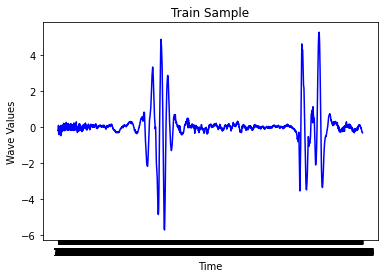

[0.19974905 0.17925394 0.14663519 ... 0.1793107  0.24080376 0.20386949]


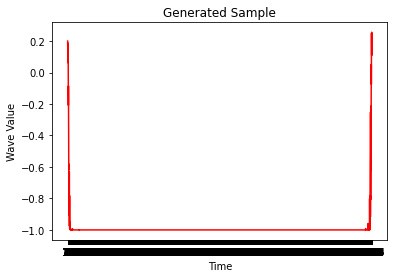

[1/100] - loss_d: 1.379, loss_g: 0.695
tensor([[-0.1559, -0.1747, -0.1322,  ..., -0.2579, -0.2087, -0.1418]],
       device='cuda:0')


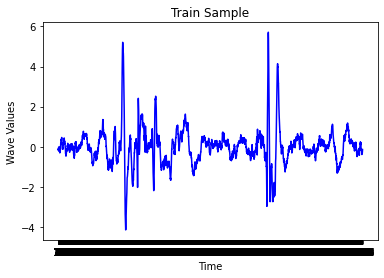

[ 0.26622587 -0.24421534 -0.25858235 ... -0.02144263  0.05381947
 -0.05254659]


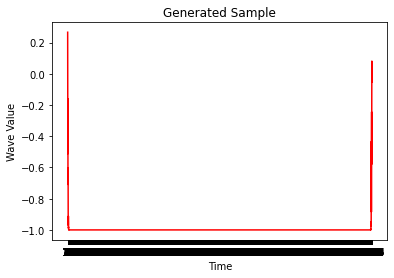

[2/100] - loss_d: 1.285, loss_g: 0.748
tensor([[-0.1382, -0.1667, -0.1697,  ...,  0.1156,  0.1364,  0.1581]],
       device='cuda:0')


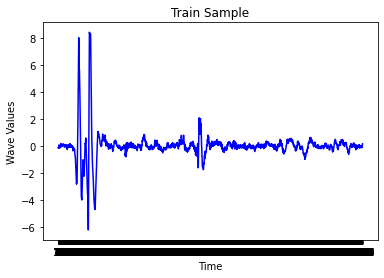

[ 0.11074072 -0.59038305  0.10303441 ... -0.2492277   0.540512
 -0.11871059]


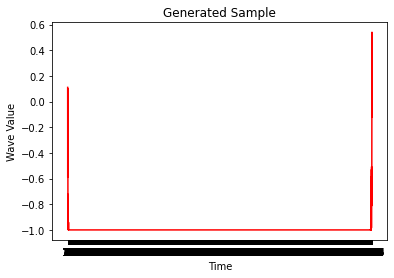

[3/100] - loss_d: 0.943, loss_g: 1.004
tensor([[ 5.1558e-02,  2.1215e-01,  4.0251e-01,  ..., -2.7337e-04,
         -1.7439e-02,  2.8468e-02]], device='cuda:0')


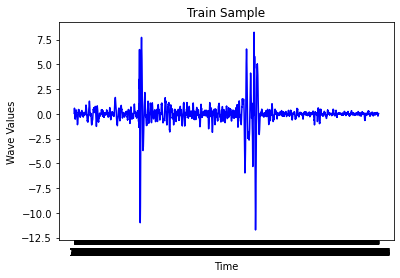

[ 0.88250995 -0.9166316   0.9420599  ... -0.3310883   0.92180216
 -0.46910876]


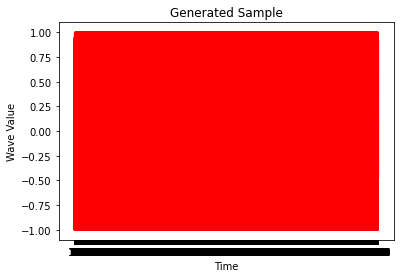

[4/100] - loss_d: 0.612, loss_g: 1.429
tensor([[0.0010, 0.0011, 0.0011,  ..., 0.0011, 0.0012, 0.0012]],
       device='cuda:0')


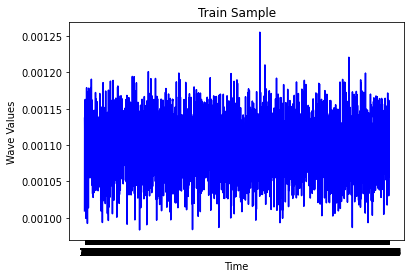

[ 0.8817574  -0.9317987   0.9898759  ... -0.8812276   0.85343236
  0.11821136]


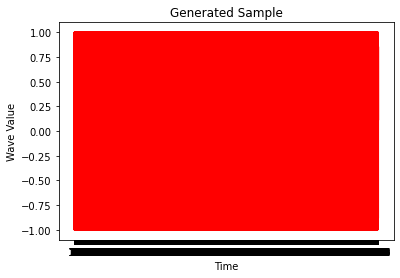

[5/100] - loss_d: 0.726, loss_g: 1.435
tensor([[-0.2457, -0.5148, -0.4509,  ..., -0.0850, -0.0822, -0.0800]],
       device='cuda:0')


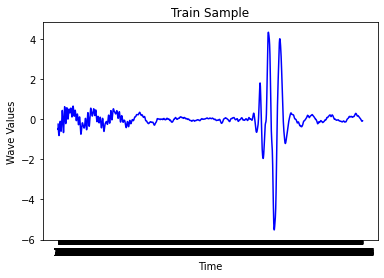

[ 0.91969347 -0.8554933   0.9955347  ...  0.25157332  0.27385354
  0.23728336]


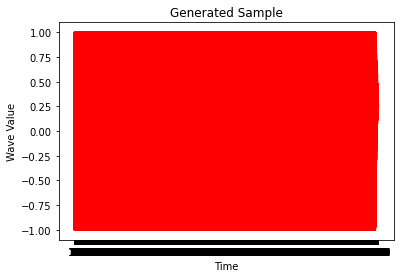

[6/100] - loss_d: 0.162, loss_g: 2.746
tensor([[1.0492, 1.2756, 1.2361,  ..., 2.1040, 1.8309, 1.4945]],
       device='cuda:0')


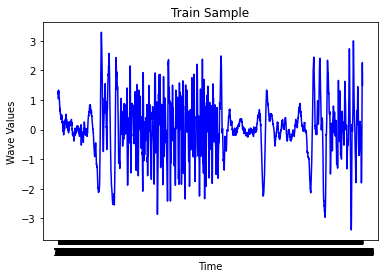

[ 0.8884263  -0.77086025  0.9130701  ...  0.21287113  0.19523975
  0.24051687]


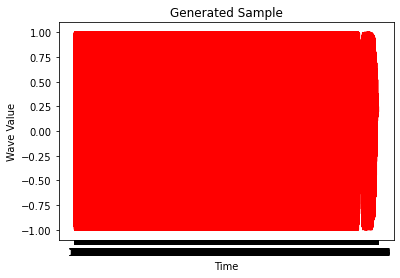

[7/100] - loss_d: 0.051, loss_g: 3.720
tensor([[-0.0754, -0.1344, -0.1922,  ...,  0.0050, -0.0107, -0.0105]],
       device='cuda:0')


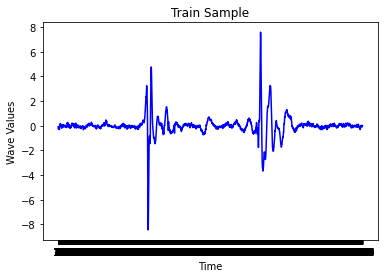

[ 0.9555602  -0.98262006  0.89867675 ...  0.3059081   0.2423622
  0.21936645]


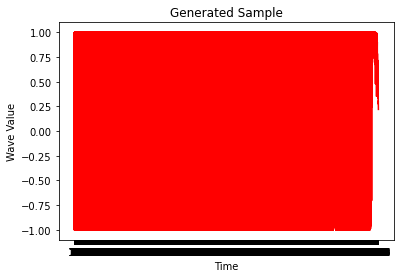

[8/100] - loss_d: 0.033, loss_g: 4.130
tensor([[0.4545, 0.5322, 0.4772,  ..., 1.0012, 0.8484, 0.7570]],
       device='cuda:0')


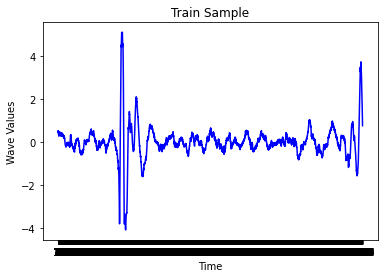

[0.8030991  0.3109495  0.68478096 ... 0.39651304 0.2500073  0.25563863]


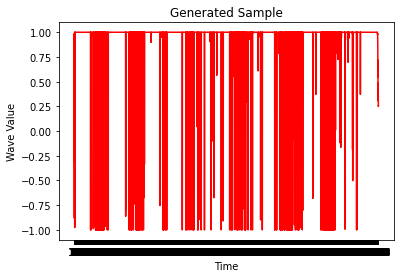

[9/100] - loss_d: 3.185, loss_g: 1.907
tensor([[-0.1283, -0.1402, -0.0809,  ..., -0.5455, -0.5419, -0.5200]],
       device='cuda:0')


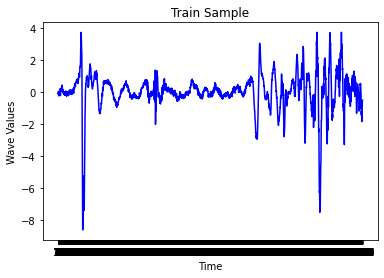

[0.05015651 0.06965788 0.80811334 ... 0.41519156 0.5069618  0.34845385]


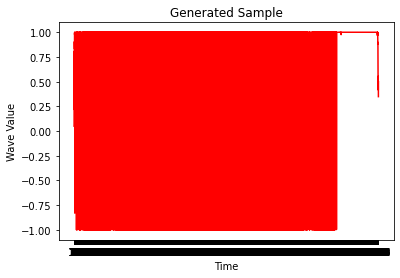

[10/100] - loss_d: 2.282, loss_g: 0.504
tensor([[-0.2584, -0.3141, -0.3044,  ...,  0.0160,  0.0350,  0.0721]],
       device='cuda:0')


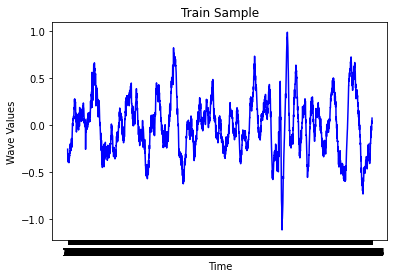

[0.5522977  0.27125823 0.1718095  ... 0.2496097  0.339574   0.37254205]


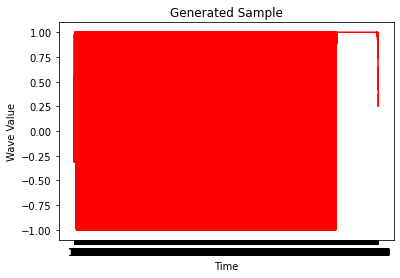

[11/100] - loss_d: 1.570, loss_g: 0.645
tensor([[ 0.0416,  0.0439,  0.1036,  ...,  0.0249,  0.0008, -0.0344]],
       device='cuda:0')


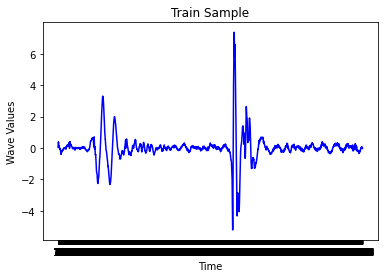

[-0.17649914  0.45027208 -0.8511313  ...  0.39446542  0.17350687
  0.35751408]


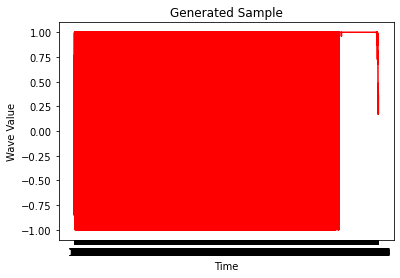

[12/100] - loss_d: 1.376, loss_g: 0.769
tensor([[ 0.1604,  0.1530,  0.1093,  ..., -0.5017, -0.6536, -0.8387]],
       device='cuda:0')


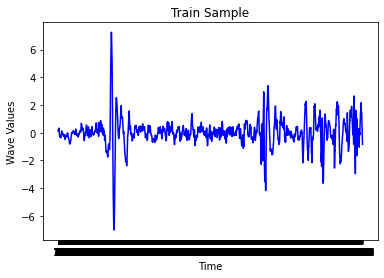

[ 0.00909281  0.282452   -0.62607706 ...  0.4670998   0.35226193
  0.47292238]


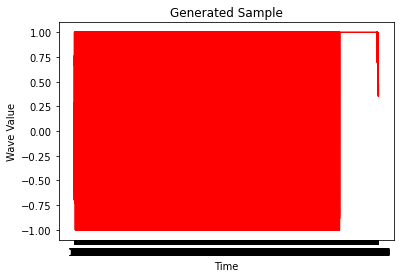

[13/100] - loss_d: 1.167, loss_g: 0.901
tensor([[-0.0661, -0.0890, -0.0921,  ..., -0.2072, -0.1980, -0.1873]],
       device='cuda:0')


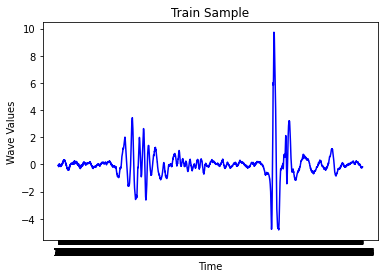

[0.03691973 0.662313   0.49709764 ... 0.4034401  0.3178399  0.36943316]


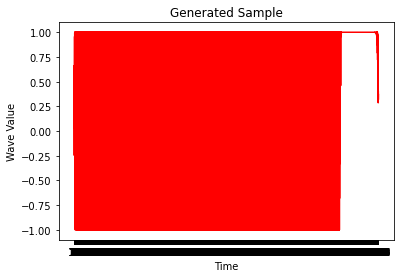

[14/100] - loss_d: 0.914, loss_g: 1.139
tensor([[ -8.8001, -10.2217,  -9.0904,  ...,  -0.2493,  -0.1579,  -0.1002]],
       device='cuda:0')


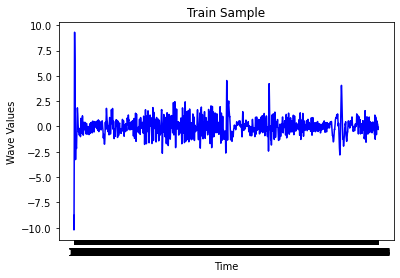

[ 0.8758116   0.54434305 -0.7891052  ...  0.5984547   0.44389975
  0.27963918]


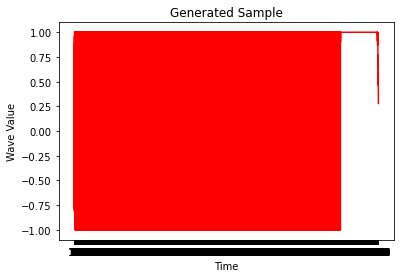

[15/100] - loss_d: 0.524, loss_g: 1.474
tensor([[ 0.1012,  0.1078, -0.0668,  ...,  0.0564, -0.0083,  0.0874]],
       device='cuda:0')


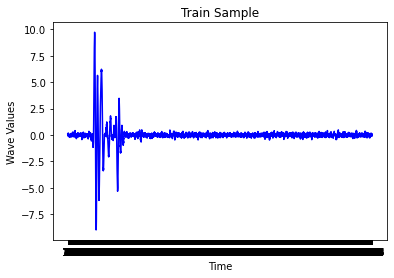

[ 0.24635068 -0.0263939  -0.6522758  ...  0.2895883   0.47903275
  0.3867513 ]


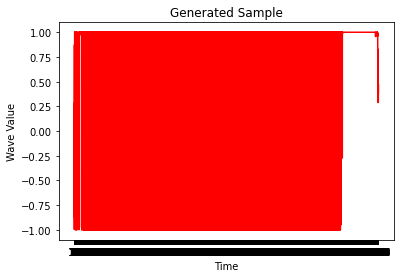

[16/100] - loss_d: 0.177, loss_g: 2.244
tensor([[-0.0922, -0.2114, -0.3645,  ..., -0.1398, -0.1580, -0.1551]],
       device='cuda:0')


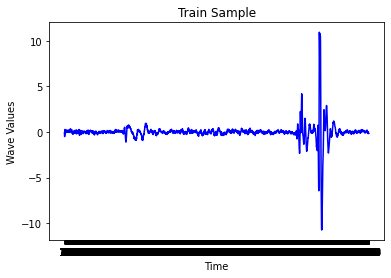

[ 0.6480845   0.36185554 -0.666533   ...  0.345695    0.2987851
  0.35453138]


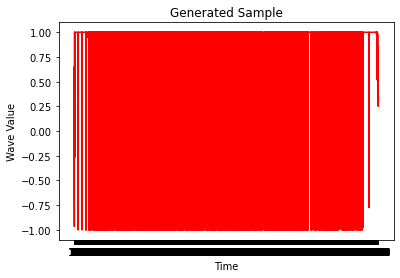

[17/100] - loss_d: 0.195, loss_g: 2.365
tensor([[-0.1696, -0.2036, -0.1868,  ...,  0.2371,  0.2149,  0.1911]],
       device='cuda:0')


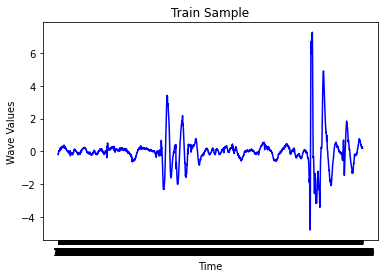

[ 0.09649202 -0.30929607 -0.9865639  ...  0.10819717  0.2862966
  0.2653775 ]


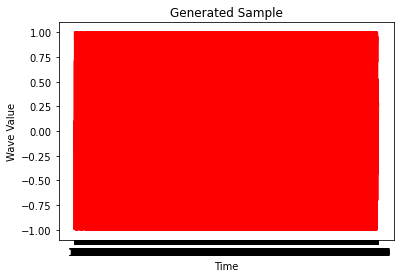

[18/100] - loss_d: 0.144, loss_g: 2.694
tensor([[-0.1993, -0.2732, -0.3214,  ...,  0.0194, -0.0088, -0.0156]],
       device='cuda:0')


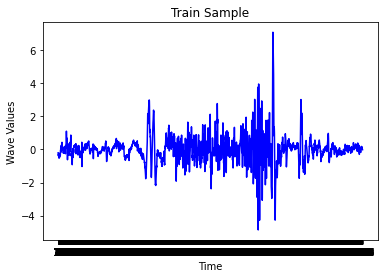

[ 0.15055256 -0.47751063 -0.77842915 ...  0.18392365  0.25981688
  0.23299241]


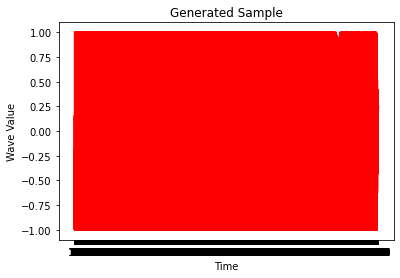

[19/100] - loss_d: 0.871, loss_g: 2.107
tensor([[ 0.0687,  0.0894,  0.0826,  ..., -0.0168,  0.0059,  0.0417]],
       device='cuda:0')


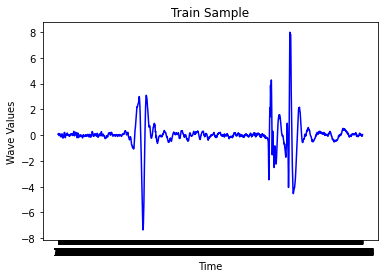

[ 0.25838172 -0.05784612 -0.01908725 ... -0.00259831  0.05419273
  0.16465062]


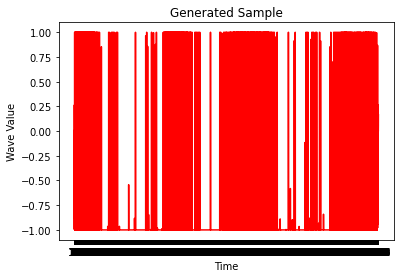

[20/100] - loss_d: 0.926, loss_g: 1.463
tensor([[-1.3467, -1.5550, -1.4013,  ..., -0.0573, -0.0639,  0.0492]],
       device='cuda:0')


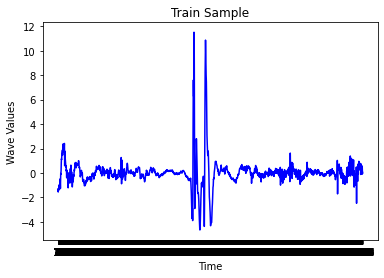

[ 0.18334329 -0.05796858 -0.00050776 ...  0.12416739  0.3127847
  0.31338283]


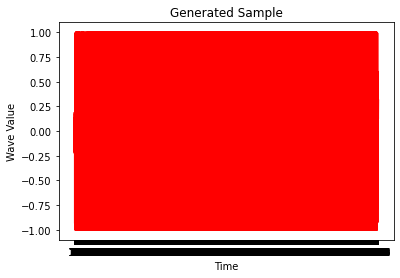

[21/100] - loss_d: 0.678, loss_g: 1.518
tensor([[ 0.0026, -0.0450, -0.1072,  ...,  0.0791, -0.0310,  0.0016]],
       device='cuda:0')


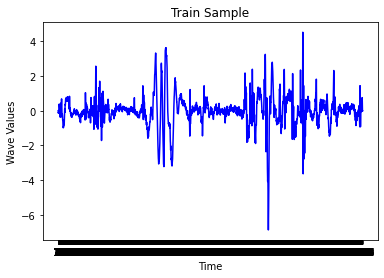

[0.00334606 0.26956338 0.42183894 ... 0.26646158 0.20041181 0.36703357]


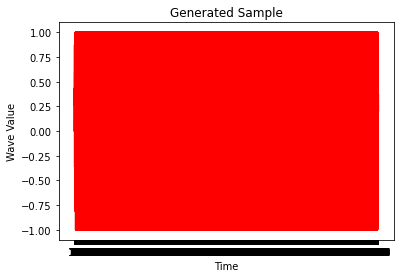

[22/100] - loss_d: 0.553, loss_g: 1.617
tensor([[-0.0136, -0.0097,  0.0070,  ...,  0.1394,  0.1361,  0.1043]],
       device='cuda:0')


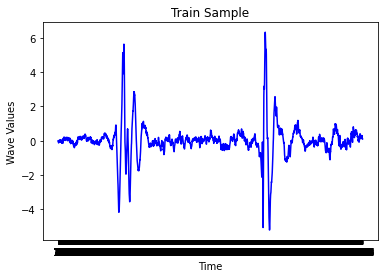

[0.34805003 0.23581514 0.2847904  ... 0.38035437 0.18534689 0.28307092]


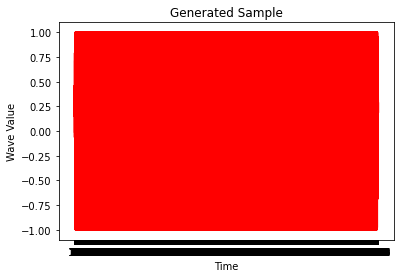

[23/100] - loss_d: 0.476, loss_g: 1.873
tensor([[-0.0655, -0.0366,  0.0453,  ..., -1.0336, -0.9878, -0.9328]],
       device='cuda:0')


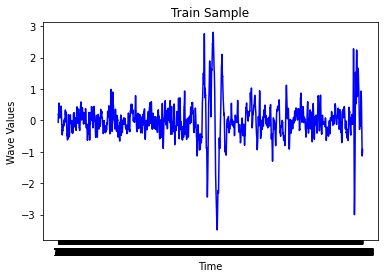

[0.21289903 0.28831473 0.28827494 ... 0.26315993 0.24053149 0.2220972 ]


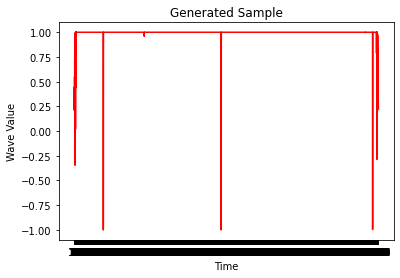

[24/100] - loss_d: 0.275, loss_g: 2.321
tensor([[ 0.3374,  0.5946,  0.5057,  ..., -0.2127, -0.2808, -0.6548]],
       device='cuda:0')


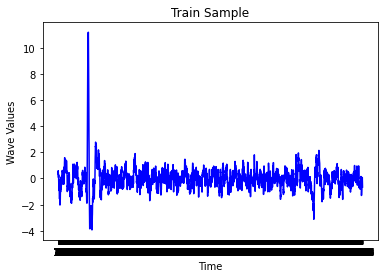

[0.26133284 0.23219556 0.29142955 ... 0.48154774 0.10417782 0.32198858]


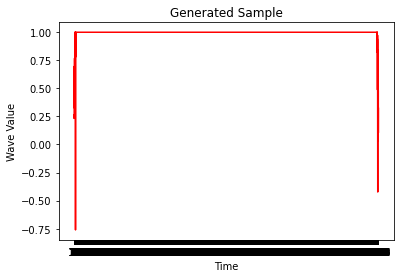

[25/100] - loss_d: 0.153, loss_g: 3.166
tensor([[-0.4272, -0.3602, -0.1534,  ...,  0.4527,  0.5256,  0.5496]],
       device='cuda:0')


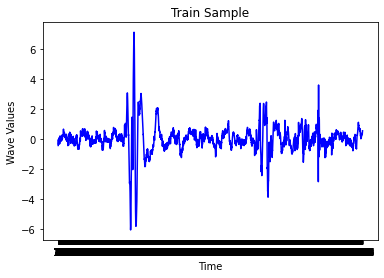

[0.22894514 0.32980826 0.25944164 ... 0.29967532 0.10435634 0.2901768 ]


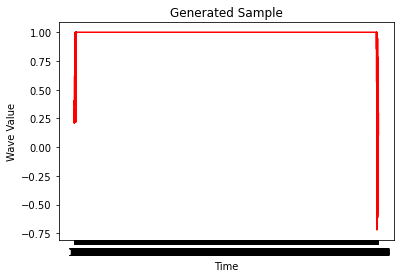

[26/100] - loss_d: 0.070, loss_g: 3.529
tensor([[ 0.1161,  0.2864,  0.4074,  ..., -0.0693, -0.1374, -0.0477]],
       device='cuda:0')


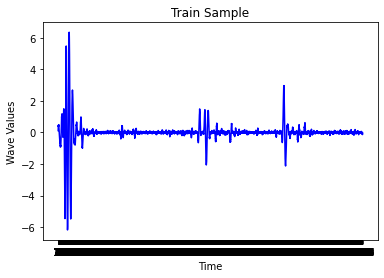

[0.14748055 0.2682761  0.4054192  ... 0.58935    0.07366616 0.42796552]


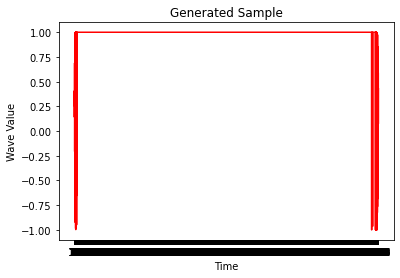

[27/100] - loss_d: 0.046, loss_g: 3.847
tensor([[-0.0393, -0.0509, -0.0530,  ..., -0.2910, -0.2494, -0.2166]],
       device='cuda:0')


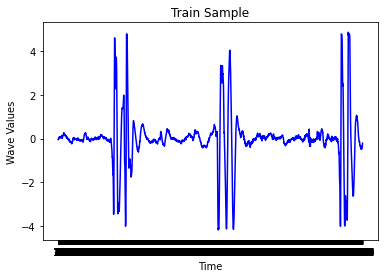

[0.15519856 0.18407835 0.19591749 ... 0.52922565 0.00228765 0.26547807]


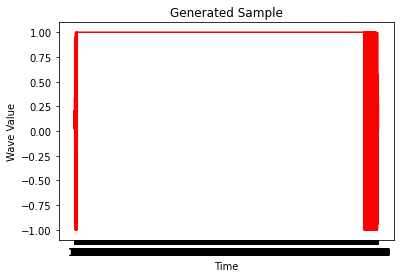

[28/100] - loss_d: 0.036, loss_g: 4.055
tensor([[0.4135, 0.4218, 0.3306,  ..., 0.2107, 0.2558, 0.3558]],
       device='cuda:0')


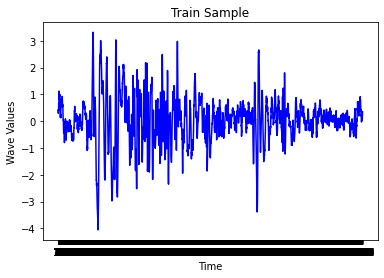

[ 0.21655779 -0.20700231  0.02632238 ... -0.33414644  0.07506345
  0.30030274]


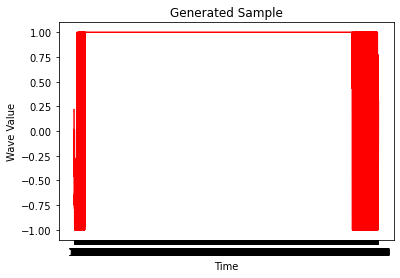

[29/100] - loss_d: 0.033, loss_g: 4.157
tensor([[ 0.3374,  0.5946,  0.5057,  ..., -0.2127, -0.2808, -0.6548]],
       device='cuda:0')


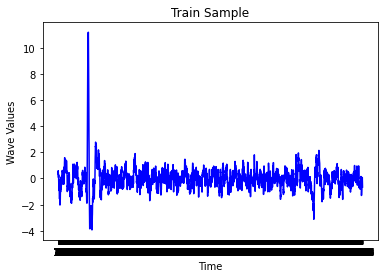

[ 0.1149435  -0.8908795  -0.85064965 ...  0.9902879   0.16845278
  0.68353415]


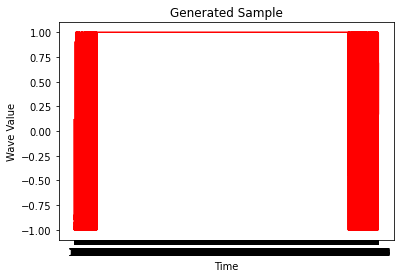

[30/100] - loss_d: 0.035, loss_g: 4.190
tensor([[-0.0744, -0.0561, -0.0255,  ...,  0.1956,  0.2075,  0.2144]],
       device='cuda:0')


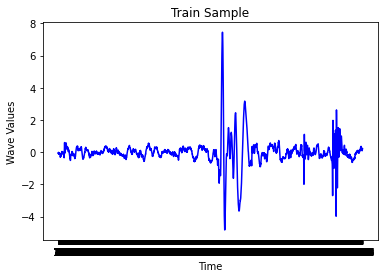

[-0.81388074 -0.58988225 -0.90968686 ...  0.17914979  0.17863475
  0.16354468]


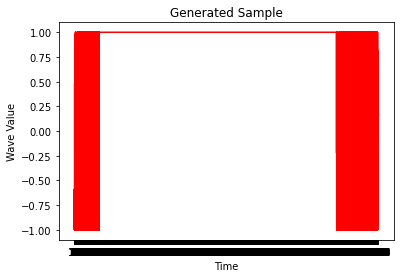

[31/100] - loss_d: 0.024, loss_g: 4.297
tensor([[-0.6784, -0.7295, -0.6094,  ...,  0.1355,  0.1609,  0.2182]],
       device='cuda:0')


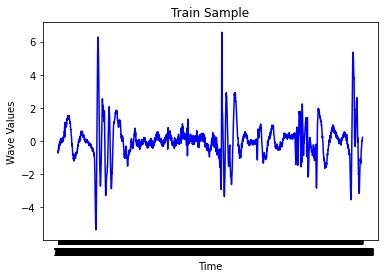

[-0.3823731  -0.9999443  -0.9984489  ... -0.21714708  0.56596625
  0.5538513 ]


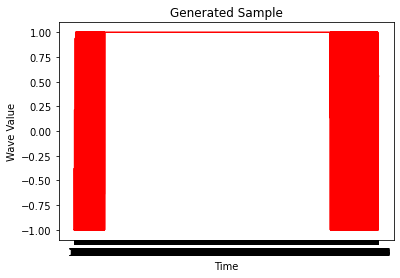

[32/100] - loss_d: 0.025, loss_g: 4.330
tensor([[-0.0048, -0.0048, -0.0048,  ..., -0.0048, -0.0048, -0.0048]],
       device='cuda:0')


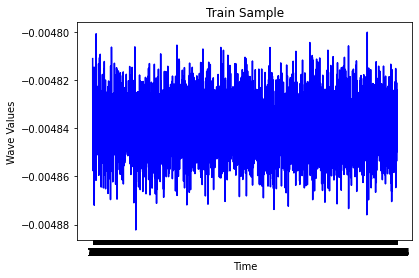

[ 0.2727904  -0.93042433 -0.89439195 ...  0.63368064 -0.7382355
  0.847847  ]


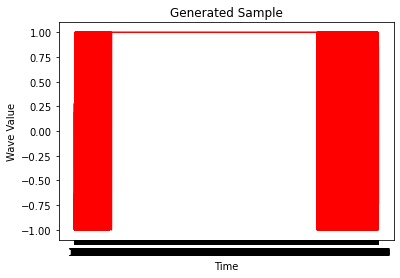

[33/100] - loss_d: 0.025, loss_g: 4.355
tensor([[0.0355, 0.0175, 0.0336,  ..., 1.4165, 1.4071, 1.3895]],
       device='cuda:0')


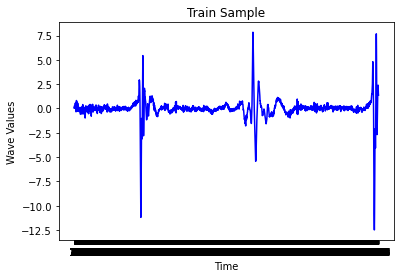

[ 0.00760405 -0.276146   -0.9964466  ...  0.8225872   0.30670866
  0.8864075 ]


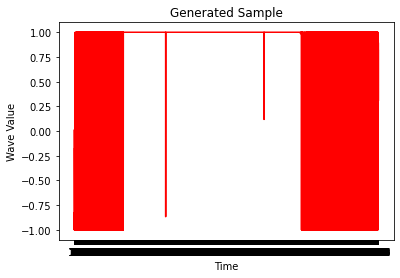

[34/100] - loss_d: 0.033, loss_g: 4.116
tensor([[-0.1993, -0.2732, -0.3214,  ...,  0.0194, -0.0088, -0.0156]],
       device='cuda:0')


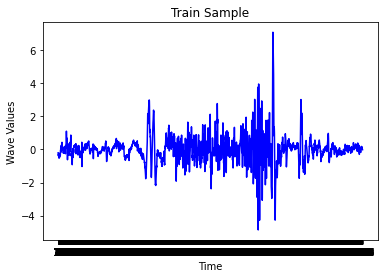

[ 0.3510584  -0.9190704  -0.99967664 ...  0.9680737   0.28210315
  0.87858665]


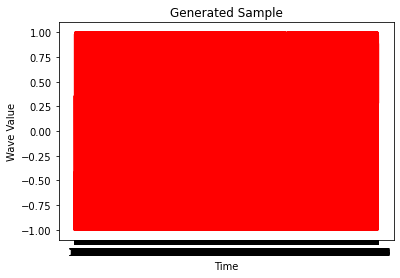

[35/100] - loss_d: 0.140, loss_g: 3.126
tensor([[-0.0199, -0.0447, -0.0460,  ..., -0.0873, -0.1015, -0.0731]],
       device='cuda:0')


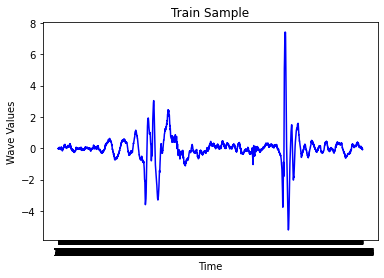

[ 0.6038038  -0.9996713  -0.99106693 ... -0.9316001   0.9867756
  0.9403589 ]


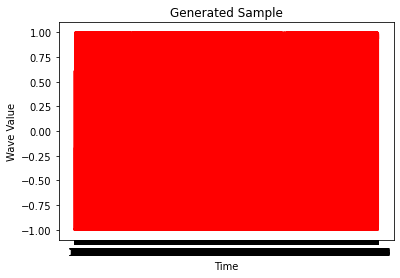

[36/100] - loss_d: 0.295, loss_g: 2.459
tensor([[ 0.0241, -0.0329, -0.1503,  ..., -0.7380, -0.8052, -0.9914]],
       device='cuda:0')


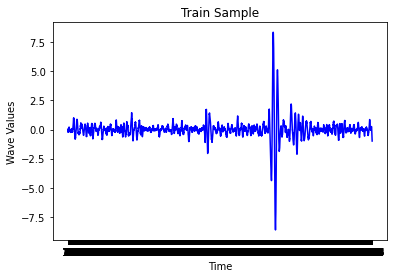

[-0.00907356 -0.88678676 -0.99115837 ...  0.22606921  0.73722184
  0.87256753]


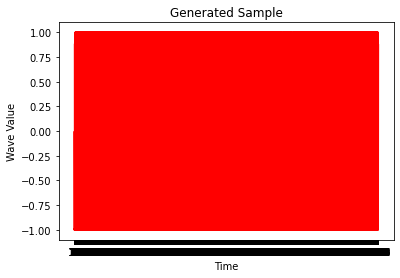

[37/100] - loss_d: 0.169, loss_g: 2.708
tensor([[-0.0250, -0.0497, -0.0346,  ...,  0.5230,  0.4302,  0.3502]],
       device='cuda:0')


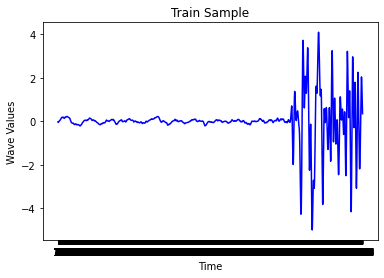

[ 0.48322275 -0.9201979  -0.9999979  ...  0.9889365   0.6112895
  0.8930546 ]


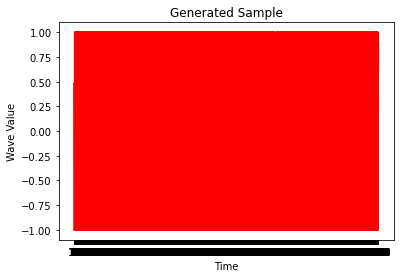

[38/100] - loss_d: 0.142, loss_g: 2.952
tensor([[-0.4652, -0.5099, -0.4435,  ..., -1.1873, -1.1488, -1.0891]],
       device='cuda:0')


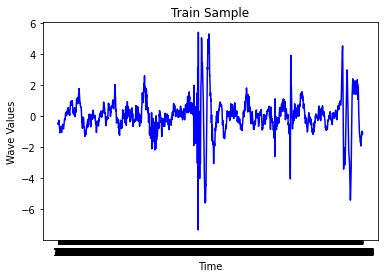

[ 0.28584465 -0.9999992  -0.9999836  ...  0.94291073  0.99607825
  0.9046371 ]


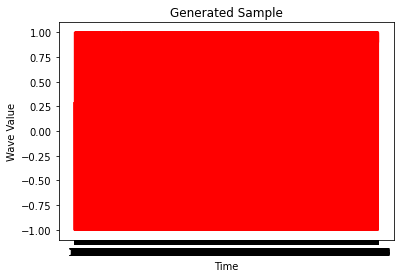

[39/100] - loss_d: 0.200, loss_g: 2.711
tensor([[ 0.7762,  0.9173,  0.8558,  ..., -0.7266, -0.7690, -0.8183]],
       device='cuda:0')


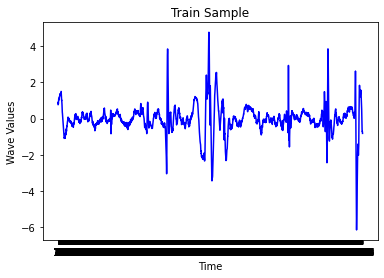

[ 0.9896517  -0.9999647  -0.9999498  ...  0.9746375   0.07700381
  0.09982431]


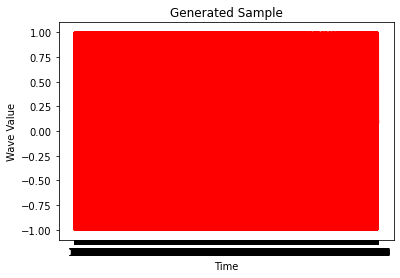

[40/100] - loss_d: 0.251, loss_g: 2.623
tensor([[0.1032, 0.0970, 0.0639,  ..., 0.5722, 0.3975, 0.3023]],
       device='cuda:0')


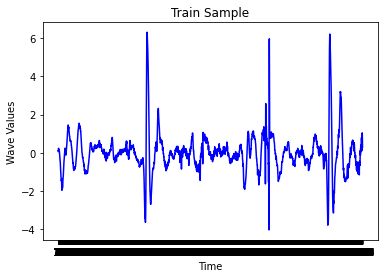

[-0.31436065 -0.87617236 -0.9999994  ...  0.7691337   0.4162953
  0.6230241 ]


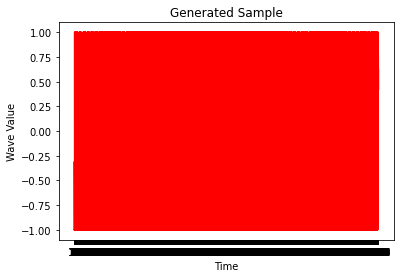

[41/100] - loss_d: 0.114, loss_g: 3.086
tensor([[-0.1391, -0.1145, -0.0386,  ...,  0.0403,  0.0692,  0.1101]],
       device='cuda:0')


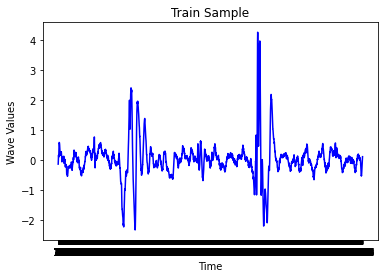

[ 0.99927986 -0.9993156  -0.99969894 ...  0.9858891   0.02431734
  0.9991584 ]


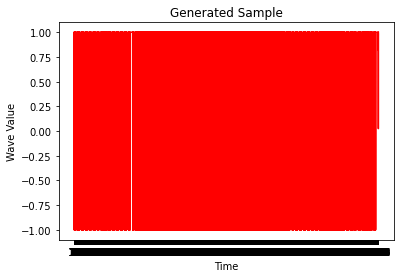

[42/100] - loss_d: 0.106, loss_g: 3.288
tensor([[ 0.0978,  0.0798, -0.0037,  ...,  0.0508,  0.0035, -0.0159]],
       device='cuda:0')


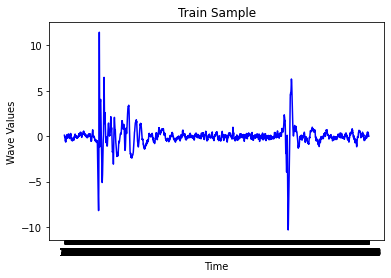

[ 0.99870205 -0.999978   -1.         ...  0.9999999  -0.98677176
  0.20713209]


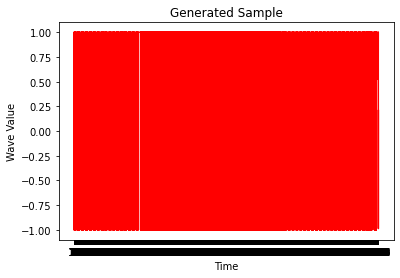

[43/100] - loss_d: 0.109, loss_g: 3.407
tensor([[-0.0399,  0.0106,  0.0639,  ..., -0.3697, -0.2424, -0.0805]],
       device='cuda:0')


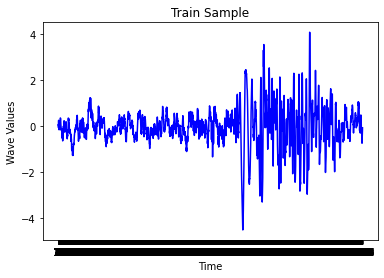

[ 0.9805695  -0.9950179  -0.9999876  ...  0.99997824 -0.09887829
  0.99887913]


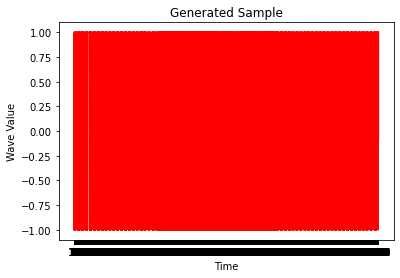

[44/100] - loss_d: 0.092, loss_g: 3.579
tensor([[ 1.3853,  1.5940,  1.4324,  ..., -1.1677, -1.2578, -1.3639]],
       device='cuda:0')


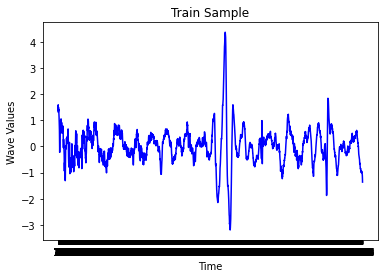

[ 0.9876047 -0.9935938  0.5110151 ...  0.9995627 -0.9431106  0.9999995]


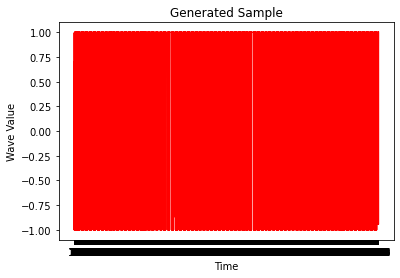

[45/100] - loss_d: 0.096, loss_g: 3.500
tensor([[-0.3717, -0.4045, -0.3288,  ..., -0.0685, -0.0593, -0.0973]],
       device='cuda:0')


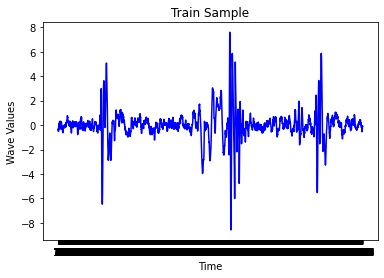

[-0.34645528 -0.9843011  -0.99979514 ...  0.998858    0.53797436
  0.54981315]


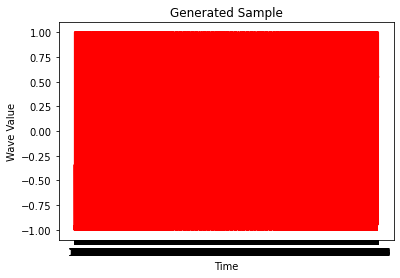

[46/100] - loss_d: 0.109, loss_g: 3.643
tensor([[-0.0467, -0.0209,  0.0899,  ...,  0.0226, -0.0410, -0.0003]],
       device='cuda:0')


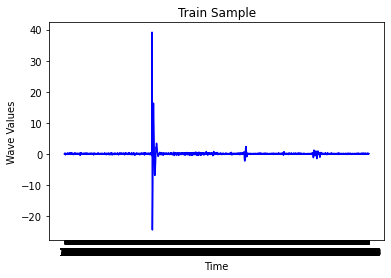

[ 0.9998131  -0.99999994 -0.99999833 ...  0.99476945 -0.9998413
  0.97638714]


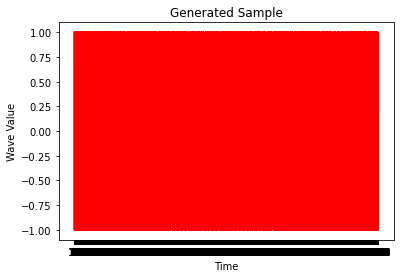

[47/100] - loss_d: 0.085, loss_g: 3.660
tensor([[-0.0135, -0.0119, -0.0036,  ...,  0.0468,  0.0467,  0.0644]],
       device='cuda:0')


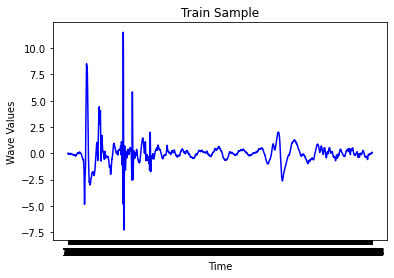

[ 0.9998264  -0.9458966  -0.99999976 ...  1.          0.5287129
  0.99999696]


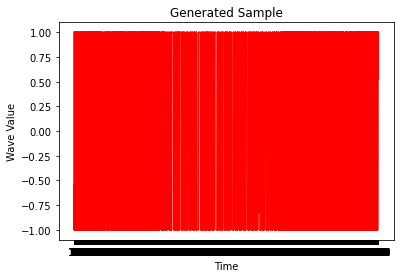

[48/100] - loss_d: 0.137, loss_g: 3.307
tensor([[0.0235, 0.0293, 0.0178,  ..., 0.1019, 0.0836, 0.0858]],
       device='cuda:0')


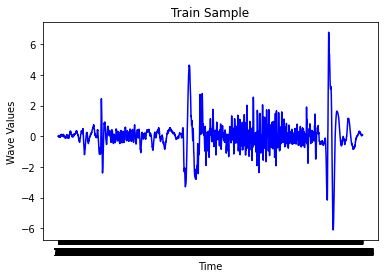

[ 0.51828146  0.90605533 -0.9941597  ... -0.99642605  0.73794675
  0.99009   ]


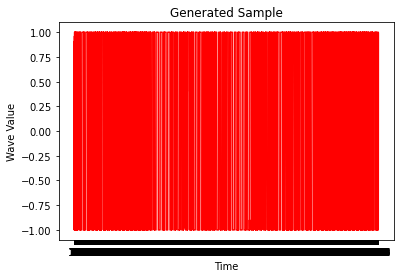

[49/100] - loss_d: 0.245, loss_g: 2.896
tensor([[ 0.0840,  0.1058,  0.1115,  ..., -0.0773, -0.0769, -0.0790]],
       device='cuda:0')


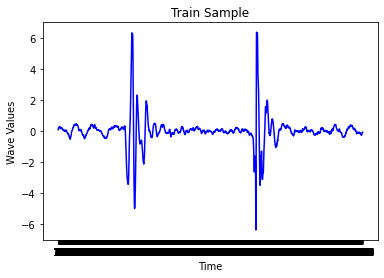

[-1.        -1.        -1.        ... -0.9999999 -0.960438  -0.6135589]


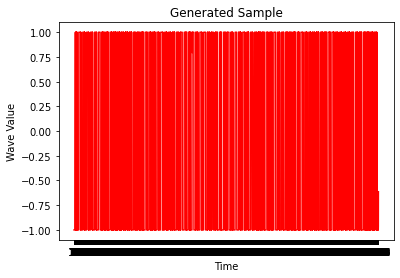

[50/100] - loss_d: 0.262, loss_g: 2.921
tensor([[-0.2017, -0.2412, -0.2325,  ...,  0.1024,  0.1147,  0.1421]],
       device='cuda:0')


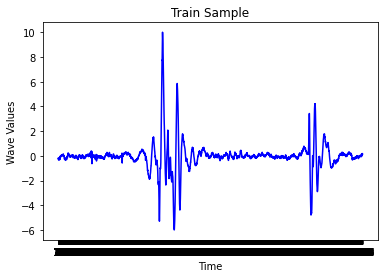

[-0.99999267 -1.         -1.         ... -1.          0.70722723
  0.9999543 ]


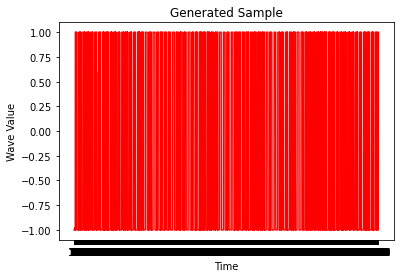

[51/100] - loss_d: 0.127, loss_g: 3.457
tensor([[0.7218, 1.3472, 1.1756,  ..., 0.7712, 0.7723, 0.7762]],
       device='cuda:0')


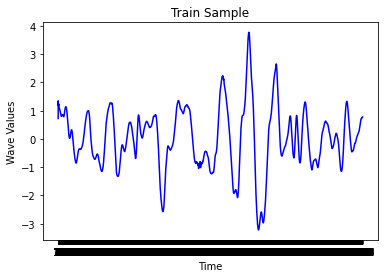

[-0.96099156 -0.99997306 -1.         ... -1.          0.6681597
  0.53504217]


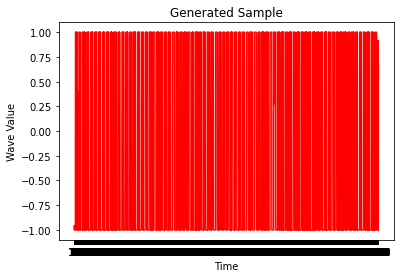

[52/100] - loss_d: 0.054, loss_g: 3.997
tensor([[-0.1313, -0.1187, -0.0597,  ..., -0.3919, -0.5167, -0.7307]],
       device='cuda:0')


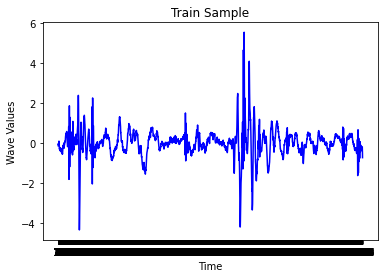

[-1.         -1.         -1.         ... -1.         -0.999996
 -0.46436977]


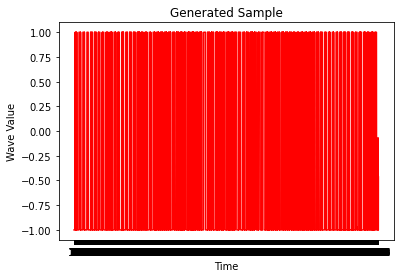

[53/100] - loss_d: 0.040, loss_g: 4.070
tensor([[-0.0199, -0.0447, -0.0460,  ..., -0.0873, -0.1015, -0.0731]],
       device='cuda:0')


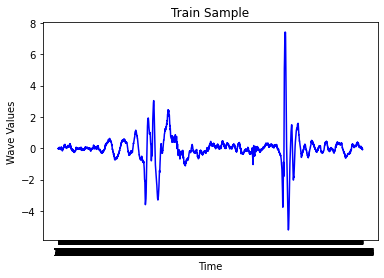

[-1.         -1.         -1.         ... -1.         -0.99999213
 -0.91015303]


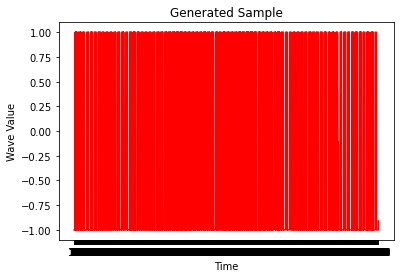

[54/100] - loss_d: 0.033, loss_g: 4.233
tensor([[0.1014, 0.1380, 0.1391,  ..., 0.2982, 0.3463, 0.4262]],
       device='cuda:0')


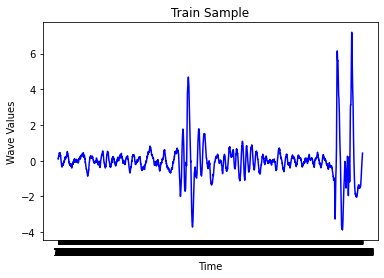

[-0.9999044  -0.99997723 -1.         ... -1.         -0.9996741
  0.05044919]


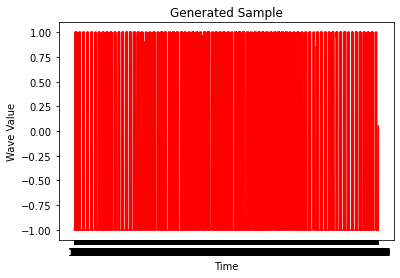

[55/100] - loss_d: 0.024, loss_g: 4.506
tensor([[-0.1526, -0.1788, -0.1636,  ..., -0.7310, -0.4758, -0.1080]],
       device='cuda:0')


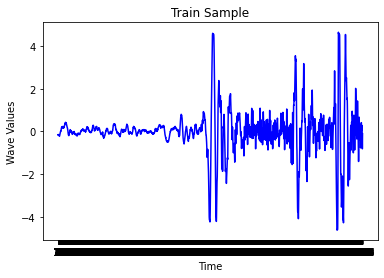

[-1.         -0.99999964 -1.         ... -1.         -0.9975219
  0.54979336]


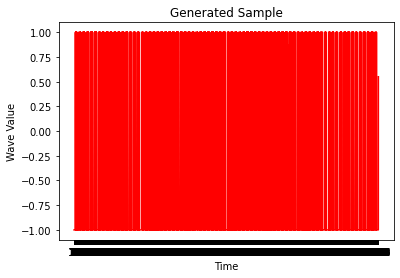

[56/100] - loss_d: 0.027, loss_g: 4.429
tensor([[-0.2603, -0.3075,  0.1688,  ..., -0.1610, -0.2671,  0.1091]],
       device='cuda:0')


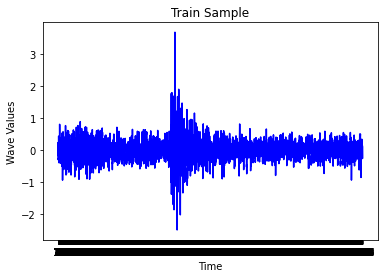

[-0.9932825  -0.9999995  -1.         ... -1.         -0.99999315
  0.15652362]


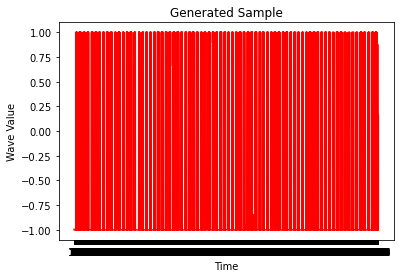

[57/100] - loss_d: 0.035, loss_g: 4.110
tensor([[ 0.0244,  0.0299,  0.0336,  ..., -0.0538, -0.0336, -0.0246]],
       device='cuda:0')


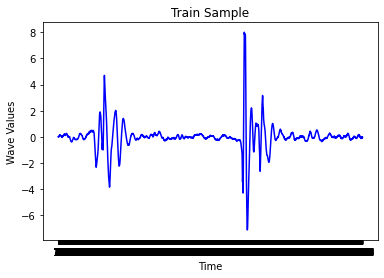

[ 0.48995116 -0.9999273  -1.         ... -1.         -1.
  0.9774144 ]


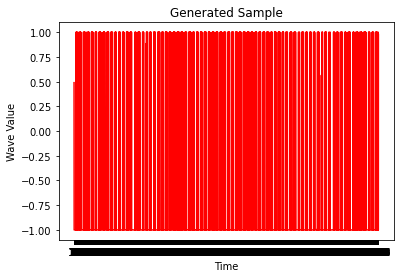

[58/100] - loss_d: 0.044, loss_g: 4.137
tensor([[ 0.3858,  0.5318,  0.5967,  ..., -0.4489, -0.3689, -0.2761]],
       device='cuda:0')


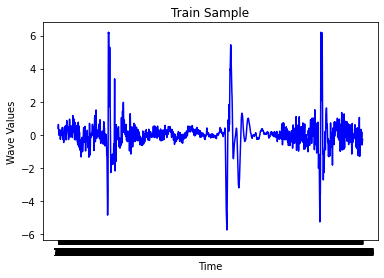

[-0.9996308  -0.99987113 -0.99995315 ... -0.9997602  -0.9998057
  0.92071486]


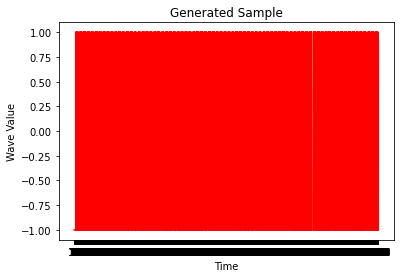

[59/100] - loss_d: 0.048, loss_g: 4.156
tensor([[0.2150, 0.2563, 0.2386,  ..., 0.0904, 0.0976, 0.1124]],
       device='cuda:0')


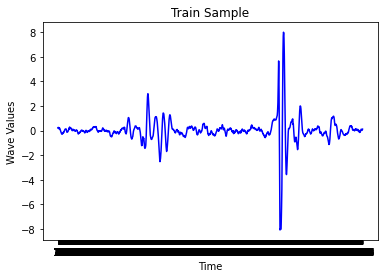

[-0.84517586 -0.8269172  -0.9994346  ... -0.9999532  -0.9996618
 -0.20610717]


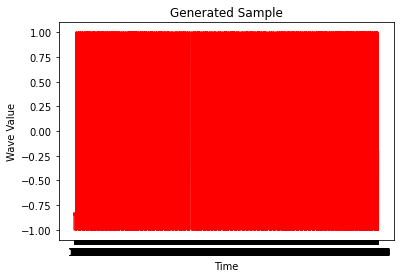

[60/100] - loss_d: 0.133, loss_g: 3.543
tensor([[-0.8078, -0.9589, -0.7468,  ..., -0.4960, -0.6910, -0.7543]],
       device='cuda:0')


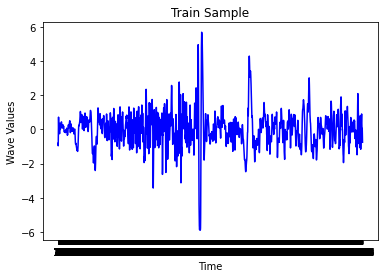

[ 0.35724393 -0.99268377 -0.42901838 ... -0.99752825 -0.99759185
  0.5375074 ]


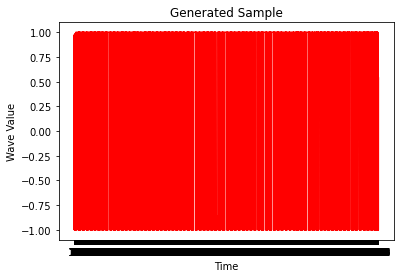

[61/100] - loss_d: 0.129, loss_g: 3.715
tensor([[ 0.6564,  0.7485,  0.6493,  ..., -3.9326, -3.8379, -3.7544]],
       device='cuda:0')


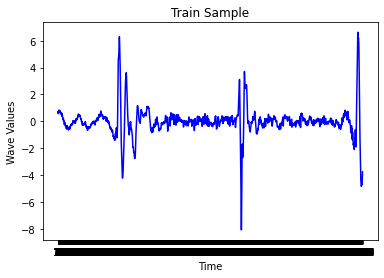

[ 0.84034073  0.9461043  -0.5824245  ... -0.93604887 -0.999931
  0.9255914 ]


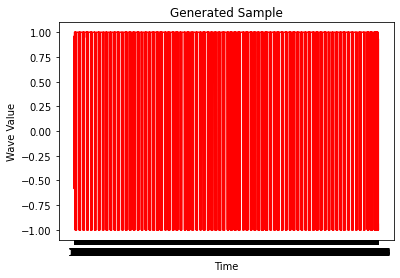

[62/100] - loss_d: 0.040, loss_g: 4.424
tensor([[0.0653, 0.0662, 0.0342,  ..., 0.1681, 0.2587, 0.2970]],
       device='cuda:0')


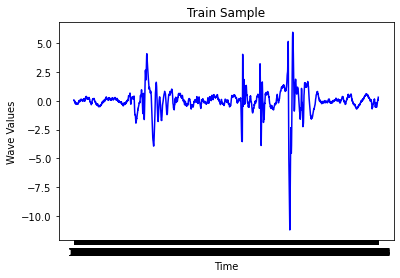

[-0.34943822 -0.9160534  -0.99833214 ... -0.20613761 -0.99936026
  0.972159  ]


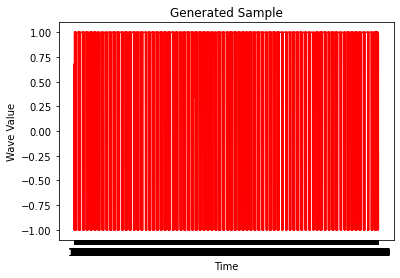

[63/100] - loss_d: 0.034, loss_g: 4.741
tensor([[-0.1863, -0.2109, -0.1914,  ..., -0.3424, -0.4129, -0.4995]],
       device='cuda:0')


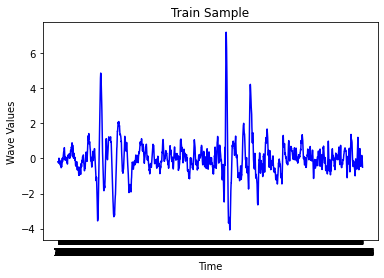

[ 0.30194888 -0.95168066 -0.9945371  ... -0.92281115 -0.55123544
  0.7473285 ]


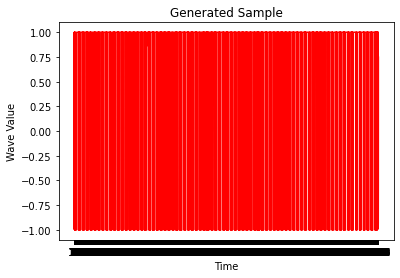

[64/100] - loss_d: 0.019, loss_g: 5.321
tensor([[-0.1904, -0.2317, -0.2206,  ...,  0.3800,  0.3733,  0.3623]],
       device='cuda:0')


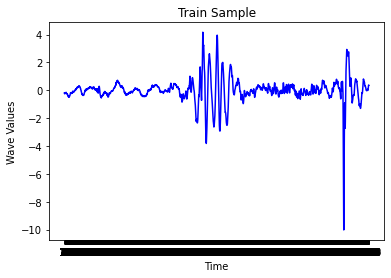

[ 0.64207435 -0.9981184  -0.99999547 ... -0.99999994 -0.99977684
  0.1726313 ]


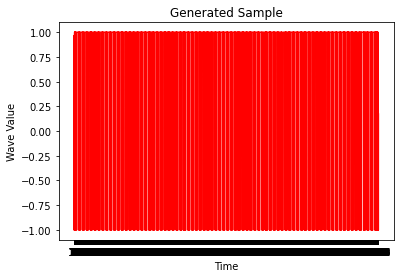

[65/100] - loss_d: 0.020, loss_g: 5.138
tensor([[-0.4272, -0.3602, -0.1534,  ...,  0.4527,  0.5256,  0.5496]],
       device='cuda:0')


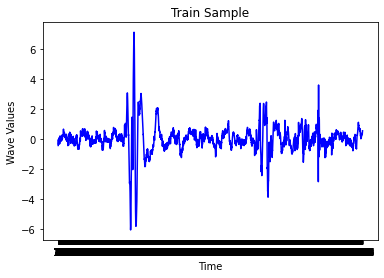

[ 0.8087466  -0.98472327 -0.9999973  ... -0.99990225 -0.8778532
  0.99930406]


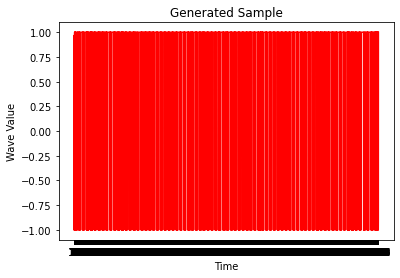

[66/100] - loss_d: 0.009, loss_g: 5.819
tensor([[-0.2542, -0.3841, -0.4610,  ...,  1.3746,  1.5004,  1.6181]],
       device='cuda:0')


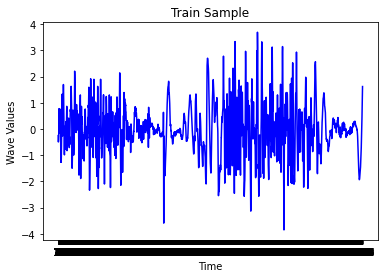

[-0.9542679  -0.97354126 -0.9996335  ... -0.99658394 -0.9363222
  0.90641   ]


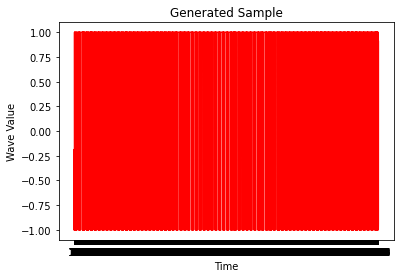

[67/100] - loss_d: 0.007, loss_g: 5.938
tensor([[-0.0305, -0.0033,  0.0446,  ..., -0.0030, -0.0075, -0.0312]],
       device='cuda:0')


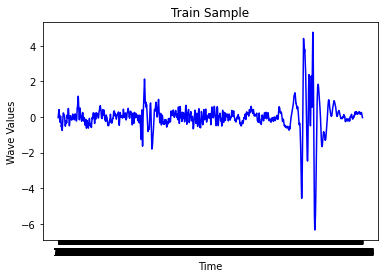

[ 0.9747724  -0.6109126  -0.995512   ... -0.9999998  -0.99999803
  0.4637469 ]


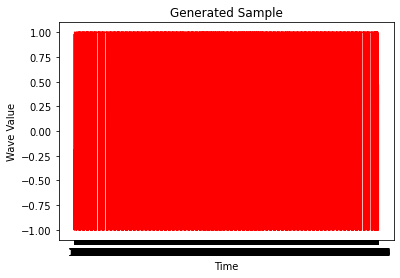

[68/100] - loss_d: 0.007, loss_g: 5.950
tensor([[-0.0033,  0.0003,  0.0005,  ...,  0.0002,  0.0020,  0.0006]],
       device='cuda:0')


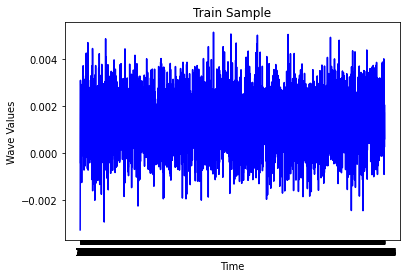

[-0.72000587 -0.99933773 -0.9999453  ... -0.9993922  -0.9998807
  0.99260944]


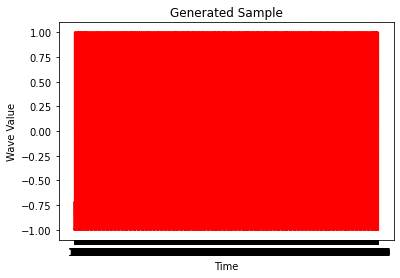

[69/100] - loss_d: 0.007, loss_g: 5.611
tensor([[0.1467, 0.1499, 0.1012,  ..., 0.4027, 0.2141, 0.0770]],
       device='cuda:0')


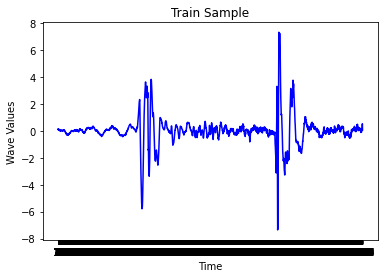

[-0.4926947  -0.9849531  -0.99998707 ... -1.         -0.928104
 -0.9699108 ]


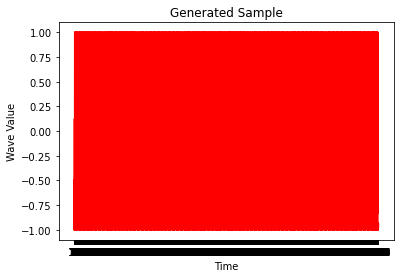

[70/100] - loss_d: 0.007, loss_g: 5.711
tensor([[-0.0135, -0.0119, -0.0036,  ...,  0.0468,  0.0467,  0.0644]],
       device='cuda:0')


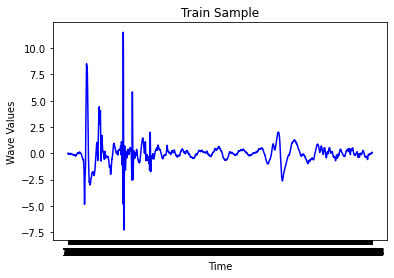

[-0.07086071 -0.98095983 -0.99995315 ... -0.99999154  0.3799459
 -0.3921418 ]


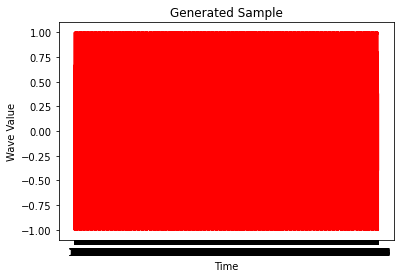

[71/100] - loss_d: 0.007, loss_g: 5.778
tensor([[-0.0101, -0.0298, -0.0497,  ..., -0.2408, -0.2120, -0.1924]],
       device='cuda:0')


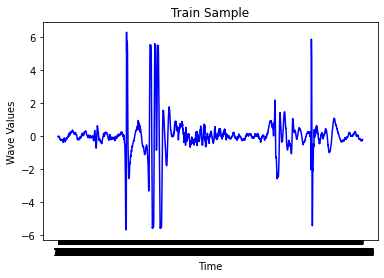

[ 0.517655    0.12062302 -0.9995944  ... -1.         -0.9999951
  0.8107681 ]


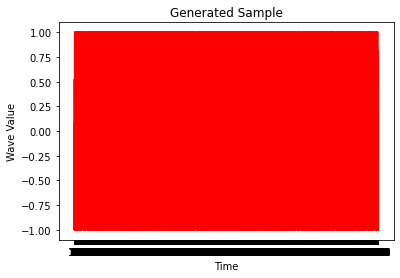

[72/100] - loss_d: 0.006, loss_g: 5.797
tensor([[ 0.0100,  0.0116,  0.0154,  ..., -0.0315,  0.0038,  0.0348]],
       device='cuda:0')


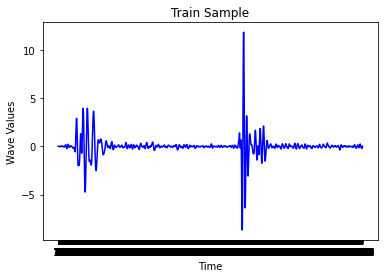

[ 0.3369518  -0.9958926  -0.9999999  ... -0.99999404 -0.9471866
  0.44014138]


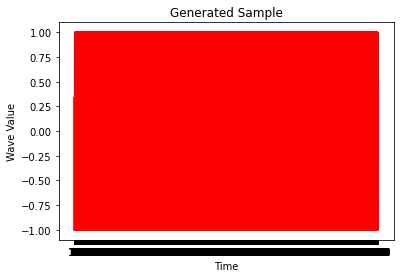

[73/100] - loss_d: 0.006, loss_g: 5.687
tensor([[0.0767, 0.1790, 0.1980,  ..., 0.6159, 0.4790, 0.3777]],
       device='cuda:0')


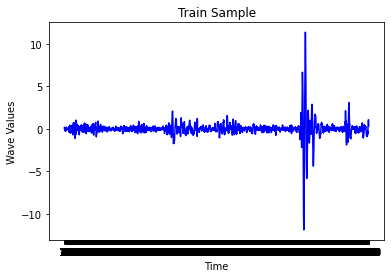

[ 0.9228989  -0.99961114 -0.99999994 ... -0.99999994 -0.9999756
  0.8177105 ]


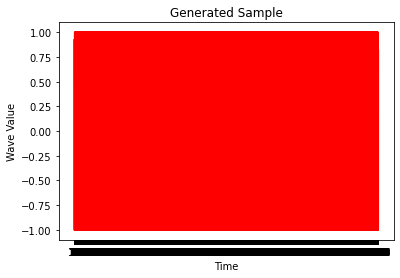

[74/100] - loss_d: 0.012, loss_g: 5.340
tensor([[ 0.0720,  0.0825,  0.0834,  ..., -0.3260, -0.3161, -0.3198]],
       device='cuda:0')


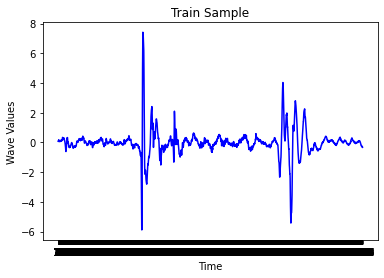

[-0.9213873  -0.9898954  -1.         ... -0.99999857 -0.9758708
 -0.82065594]


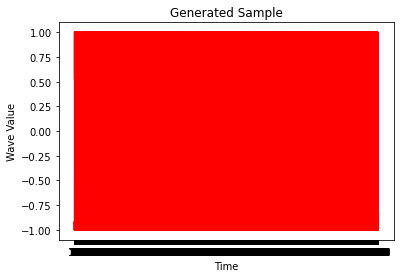

[75/100] - loss_d: 0.030, loss_g: 5.221
tensor([[ 0.1348,  0.1640,  0.1632,  ..., -0.1402, -0.1549, -0.1507]],
       device='cuda:0')


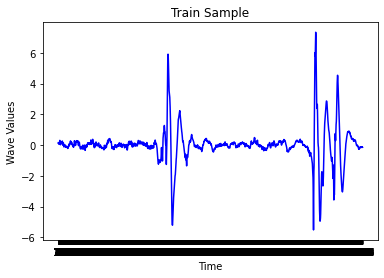

[-0.25627515 -0.98284096 -0.9999727  ... -0.99533945 -0.9784231
  0.12882192]


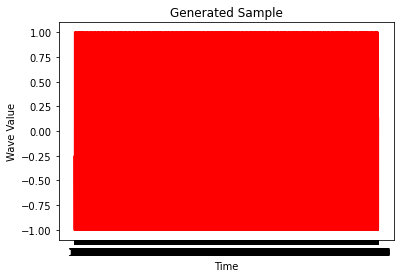

[76/100] - loss_d: 0.033, loss_g: 5.193
tensor([[-0.0588, -0.1160, -0.0896,  ..., -0.0456, -0.0524, -0.0593]],
       device='cuda:0')


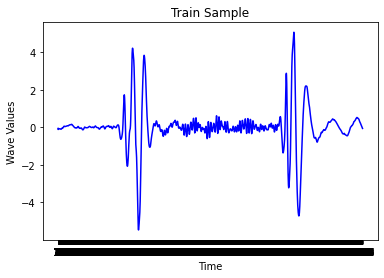

[-0.20148844 -0.99988145 -0.9999883  ... -1.         -0.9605251
 -0.95560926]


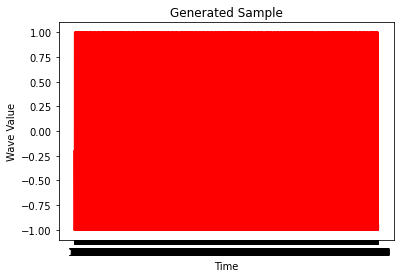

[77/100] - loss_d: 0.016, loss_g: 5.806
tensor([[-0.0563, -0.0778, -0.0869,  ..., -0.4516, -0.4141, -0.3704]],
       device='cuda:0')


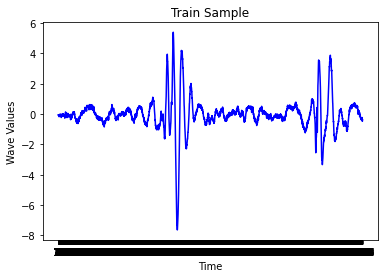

[-0.99338603 -1.         -0.99999994 ... -1.         -0.99868196
 -0.9991643 ]


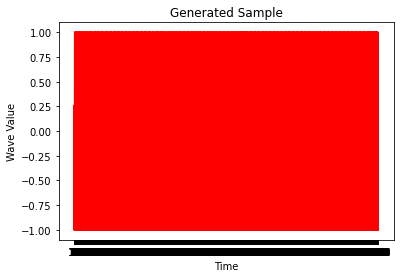

[78/100] - loss_d: 0.018, loss_g: 4.939
tensor([[-0.0728, -0.1798, -0.5317,  ...,  0.9882,  0.6328, -1.4920]],
       device='cuda:0')


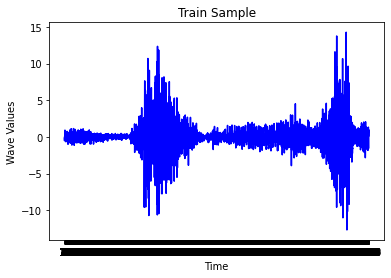

[-0.36412558 -1.         -0.9999997  ... -1.         -0.9999996
 -0.9998566 ]


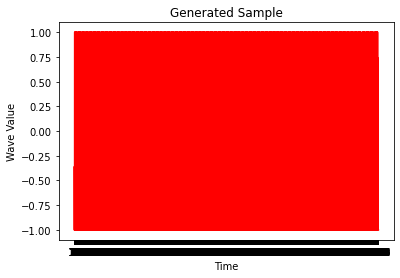

[79/100] - loss_d: 0.012, loss_g: 5.777
tensor([[0.0686, 0.0922, 0.1046,  ..., 0.2514, 0.3114, 0.3908]],
       device='cuda:0')


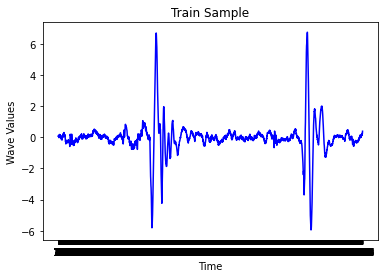

[-3.1188130e-04 -9.9379402e-01 -9.9997598e-01 ... -9.9999988e-01
 -9.9991113e-01 -8.0607295e-01]


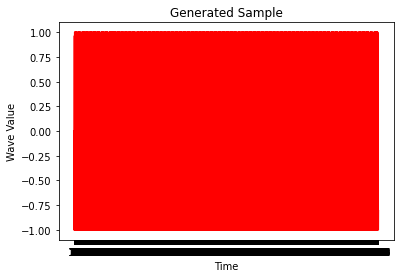

[80/100] - loss_d: 0.010, loss_g: 5.384
tensor([[-1.3725e-01, -1.5457e-01, -1.4038e-01,  ...,  2.5443e-05,
          1.2035e-02,  1.5018e-02]], device='cuda:0')


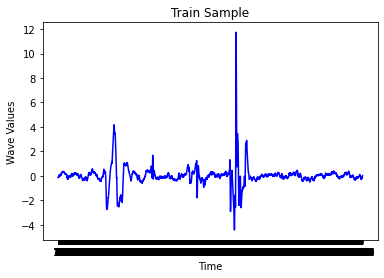

[-0.97293925 -0.9911721  -0.9958972  ... -1.         -0.9999784
 -0.99997604]


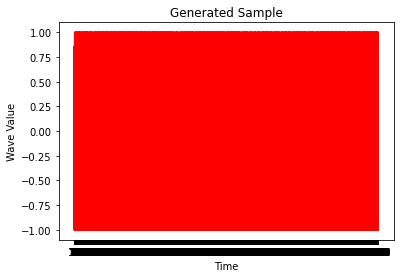

[81/100] - loss_d: 0.008, loss_g: 5.885
tensor([[0.1467, 0.1499, 0.1012,  ..., 0.4027, 0.2141, 0.0770]],
       device='cuda:0')


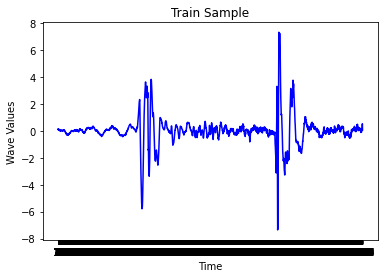

[-0.7600628  -0.9928245  -0.8581104  ... -0.9999321   0.9991136
 -0.99052656]


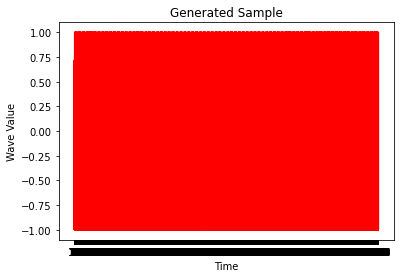

[82/100] - loss_d: 0.016, loss_g: 5.347
tensor([[-0.0317, -0.0661, -0.0524,  ..., -0.5757, -0.5359, -0.4745]],
       device='cuda:0')


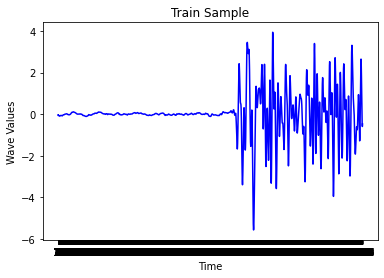

[-0.99489015 -0.9992042  -0.99998945 ... -1.         -0.99999946
 -0.5730443 ]


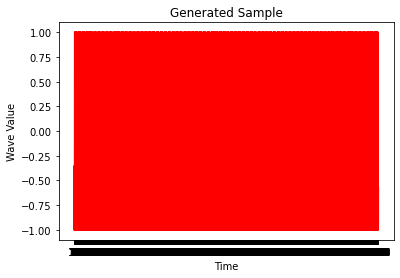

[83/100] - loss_d: 0.022, loss_g: 5.150
tensor([[-0.2483, -0.3080, -0.3062,  ...,  0.0276,  0.0350,  0.0878]],
       device='cuda:0')


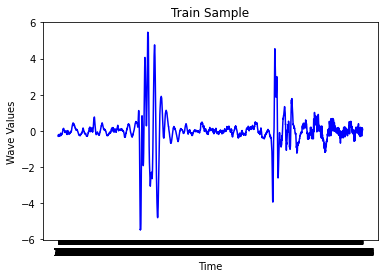

[-0.65150523 -0.8344449  -0.9999995  ... -1.         -0.9999999
 -0.9403918 ]


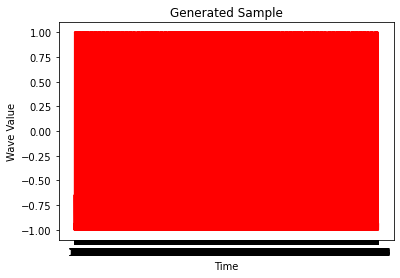

[84/100] - loss_d: 0.033, loss_g: 4.890
tensor([[ 0.0413, -0.0395,  0.0102,  ..., -0.0029, -0.0151, -0.0080]],
       device='cuda:0')


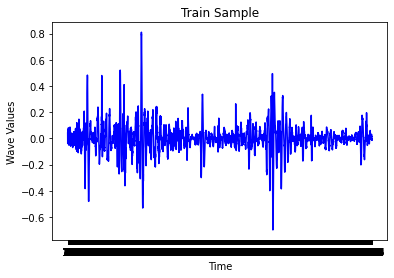

[-0.97354895 -0.98566073 -0.9999465  ... -1.         -0.999947
 -0.9999252 ]


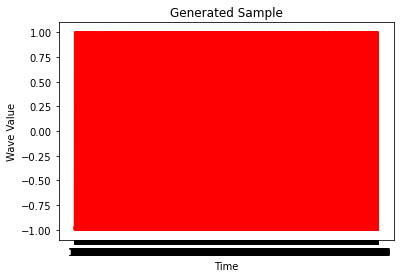

[85/100] - loss_d: 0.051, loss_g: 4.425
tensor([[ 0.0022,  0.0140,  0.0446,  ..., -1.1739,  0.5021,  1.3453]],
       device='cuda:0')


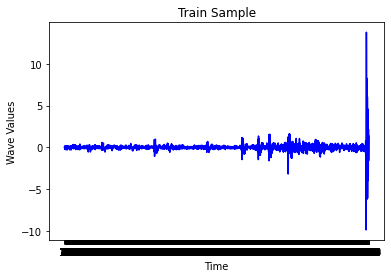

[-0.9911157  -0.99999493 -0.999819   ... -1.         -0.50980186
 -0.9816209 ]


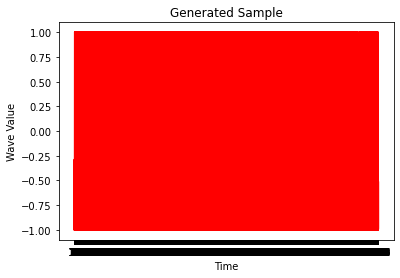

[86/100] - loss_d: 0.070, loss_g: 4.375
tensor([[ 0.2805,  0.3210,  0.2722,  ..., -0.6755, -0.8238, -0.9134]],
       device='cuda:0')


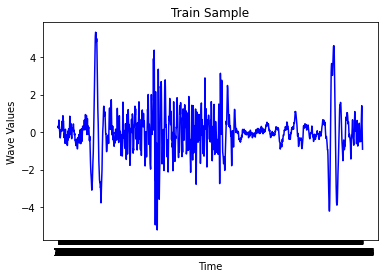

[-0.6568061  -0.9954612   0.9960484  ... -0.99998534 -1.
 -0.97390497]


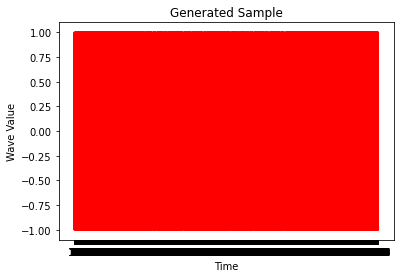

[87/100] - loss_d: 0.072, loss_g: 4.419
tensor([[0.1179, 0.1317, 0.0828,  ..., 0.0459, 0.0470, 0.0596]],
       device='cuda:0')


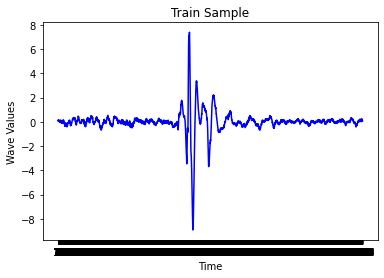

[-0.9999442  -0.99999994 -0.99999964 ... -1.         -1.
 -0.9975019 ]


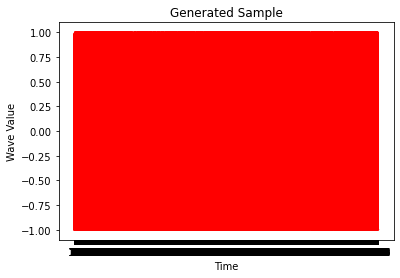

[88/100] - loss_d: 0.076, loss_g: 4.383
tensor([[-0.0683, -0.0985, -0.0963,  ...,  0.0396,  0.0598,  0.0681]],
       device='cuda:0')


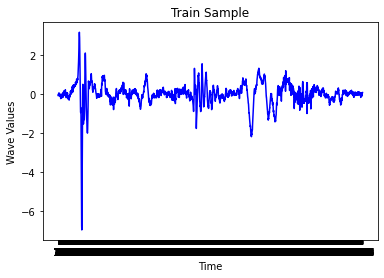

[-0.99077696 -0.99997663 -0.95714015 ... -0.99999994 -0.97589624
  0.6521481 ]


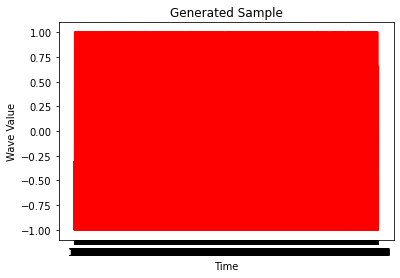

[89/100] - loss_d: 0.082, loss_g: 4.241
tensor([[-0.0583, -0.0426,  0.1339,  ...,  0.3429,  0.0585,  0.0612]],
       device='cuda:0')


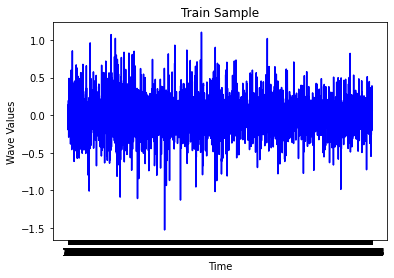

[-0.9868743  -0.99999326 -0.99853814 ... -0.8911549  -0.99999136
  0.887696  ]


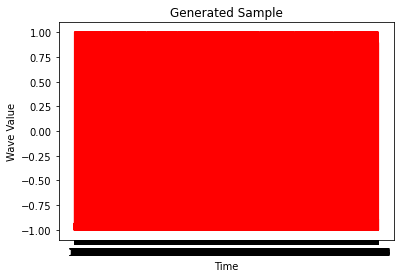

[90/100] - loss_d: 0.059, loss_g: 4.510
tensor([[0.2548, 0.3054, 0.2853,  ..., 0.0365, 0.0553, 0.1040]],
       device='cuda:0')


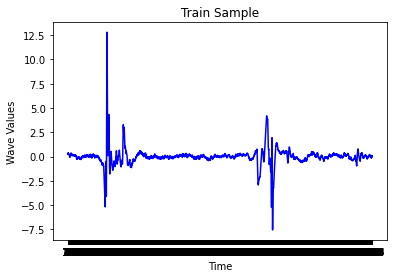

[-0.99411714 -0.9999826  -0.99999994 ... -0.99691075 -0.9999985
 -0.8009583 ]


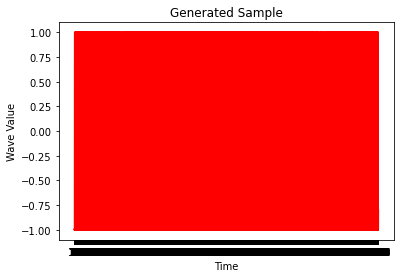

[91/100] - loss_d: 0.046, loss_g: 4.662
tensor([[ 0.0088, -0.0004, -0.0464,  ...,  0.1769,  0.0428,  0.1788]],
       device='cuda:0')


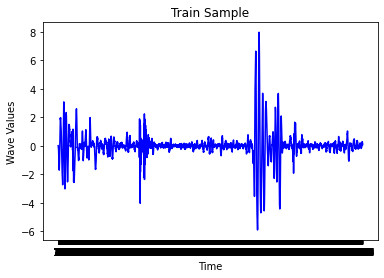

[-0.9999829 -1.        -0.9999998 ... -0.9979078 -1.         0.5132356]


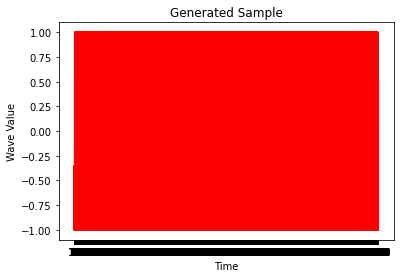

[92/100] - loss_d: 0.052, loss_g: 4.715
tensor([[-0.3112, -0.3436, -0.3153,  ..., -0.1453, -0.1425, -0.1669]],
       device='cuda:0')


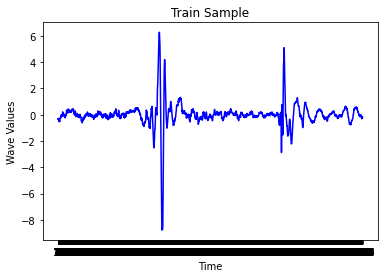

[-0.8017614  -0.99275124 -0.4414147  ... -0.99998987 -0.99999976
  0.8482219 ]


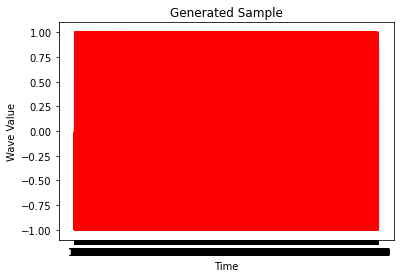

[93/100] - loss_d: 0.037, loss_g: 4.987
tensor([[-0.0467, -0.0209,  0.0899,  ...,  0.0226, -0.0410, -0.0003]],
       device='cuda:0')


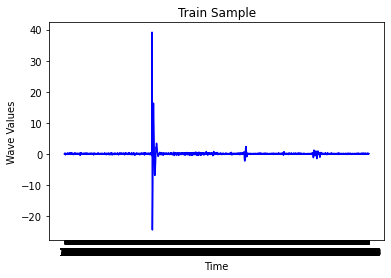

[-0.6551435  -0.96535    -0.97018325 ... -0.99999994 -0.9996459
 -0.6739458 ]


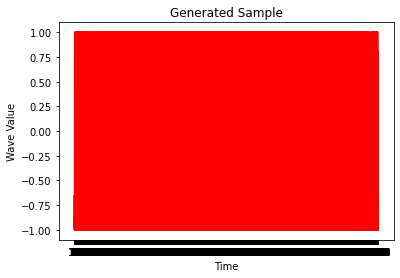

[94/100] - loss_d: 0.036, loss_g: 4.942
tensor([[-0.0760, -0.0825, -0.0450,  ...,  0.1031,  0.1016,  0.1253]],
       device='cuda:0')


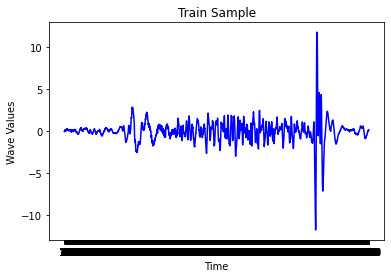

[-0.9504278  -0.99974555 -0.9962769  ...  0.9979495  -0.9999989
  0.97490615]


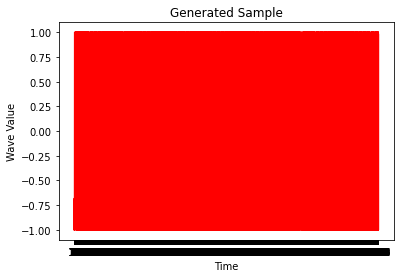

[95/100] - loss_d: 0.047, loss_g: 4.949
tensor([[-0.0016, -0.0078, -0.0190,  ...,  0.0913,  0.0914,  0.0830]],
       device='cuda:0')


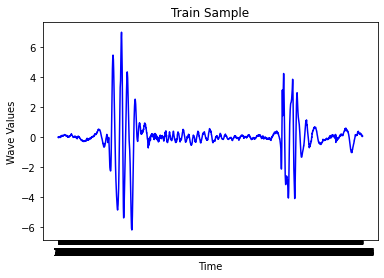

[-0.06787532 -0.40214702 -0.93363774 ... -0.98057425 -0.9359806
  0.9234387 ]


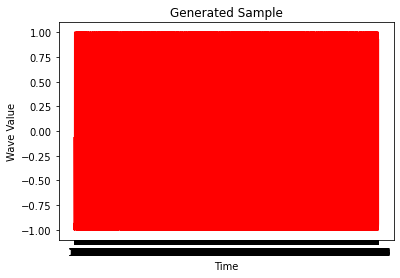

[96/100] - loss_d: 0.057, loss_g: 4.542
tensor([[0.1839, 0.2309, 0.2355,  ..., 0.0162, 0.0188, 0.0228]],
       device='cuda:0')


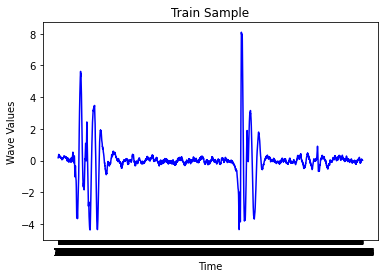

[ 0.9922323  -0.4495347  -0.97814447 ... -0.9999991   0.9932323
 -0.7676275 ]


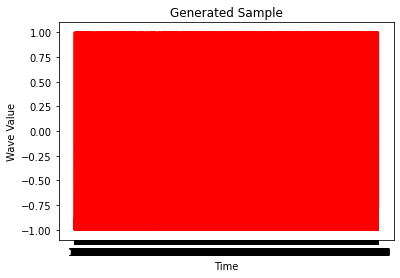

[97/100] - loss_d: 0.064, loss_g: 4.370
tensor([[0.4295, 0.5050, 0.4609,  ..., 0.0748, 0.0799, 0.1017]],
       device='cuda:0')


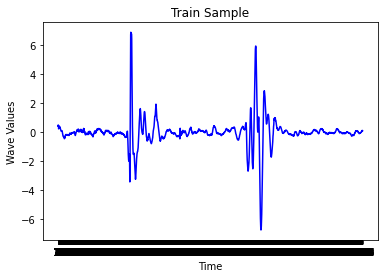

[ 0.9986011   0.95095533 -1.         ...  0.97031236 -0.994691
  0.99965644]


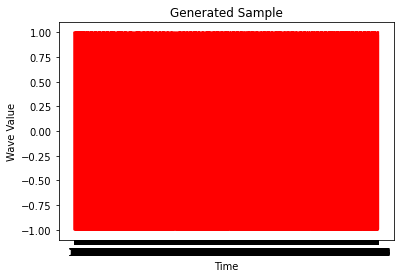

[98/100] - loss_d: 0.089, loss_g: 4.035
tensor([[-0.0636, -0.0885, -0.1063,  ..., -0.1613, -0.1110, -0.0186]],
       device='cuda:0')


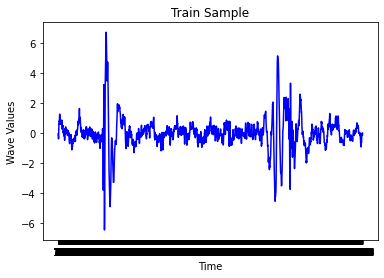

[ 0.8831172  -0.9302553  -0.99999124 ... -1.         -1.
  0.9999959 ]


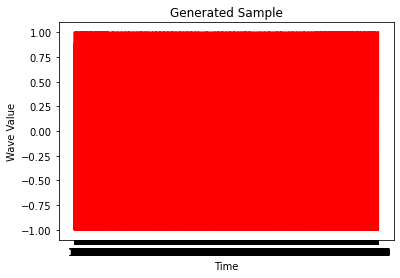

[99/100] - loss_d: 0.073, loss_g: 4.296
tensor([[-0.0026, -0.0018, -0.0032,  ..., -0.0020, -0.0023, -0.0011]],
       device='cuda:0')


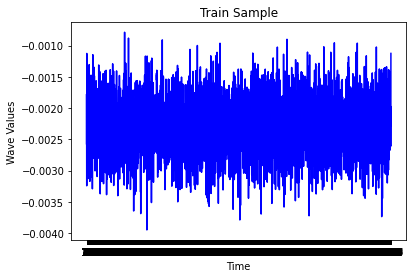

[-0.9992283  -0.99961036 -0.99997205 ... -0.9943686  -0.20675166
  0.9152694 ]


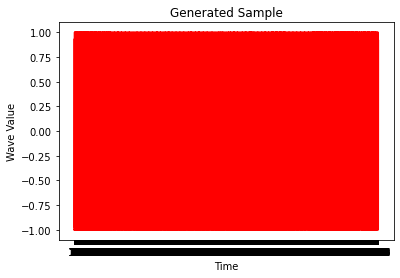

[100/100] - loss_d: 0.028, loss_g: 4.904


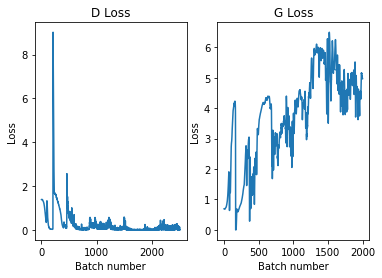

In [58]:
#Training code:

gpu_boole = torch.cuda.is_available()
cnn_boole = True #set True for CNN reshaping

#TODO tune the hyper parameter carefully to achieve a nash equilibrium
#The initial hyper parameters are not ideal, you need to tune them to make things work.
k=20
epochs = 100
batch_size = 32
lr_g = 0.0001
lr_d = 0.00002
train_interval = 5

G = generator(k)
D = discriminator()
print(G)
print(D)

if gpu_boole:
    G = G.cuda()
    D = D.cuda()
    
#data loader:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True)

#D,G optimizers:
G_optimizer = optim.Adam(G.parameters(), lr=lr_g)
D_optimizer = optim.Adam(D.parameters(), lr=lr_d)
fft = Audio2Mel(n_mel_channels=k)

#loss definition(s):
BCELoss = nn.BCELoss()

#training loop:
D_losses = []
G_losses = []
print("Training start!")
for epoch in range(epochs):
    batch_number = 0
    for x_ in train_loader:
        batch_number += 1
        #reshaping depending on your architecture class:
        #if not cnn_boole:
            #x_ = x_.view(batch_size,-1) #this reshape is needed for MLP class
        if gpu_boole:
            x_ = x_
        
        x_ = x_.float().cuda()
        # print("x_: ", x_.shape)
        # x_ = fft(x_).detach().cuda()
        # print("s_", x_.shape)
            
        #Visualize the first data input
        if batch_number == 1:
          print(x_[0])
          plt.plot([i for i, _ in enumerate(x_[0].cpu().detach().numpy()[0])], x_[0].cpu().detach().numpy()[0], color="blue")
          plt.xlabel('Time')
          plt.ylabel('Wave Values')
          plt.title('Train Sample')
          plt.xticks([i for i in range(len(x_[0].cpu().detach().numpy()[0]))])
          plt.show()
        mini_batch = x_.size()[0]
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if gpu_boole:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
        z_ = torch.randn((mini_batch, k))
        #print("PRIOR: ", z_.shape)
        if cnn_boole:
            z_ = z_.view(-1, k, 1) #needed for CNN        
        if gpu_boole:
            z_ = z_.cuda()
            
        #print("FAKE SEEDS: ", z_.shape)
        # TODO train discriminator D
        # Step 1 get prediction of D on real data x_ and calculate D_real_loss for real data
        D_pred_real = D.forward(x_)
        #print("DISCRIMINATOR PREDICTION REAL: ", D_pred_real.shape)
        D_pred_real = torch.reshape(D_pred_real, (-1,))
        D_real_loss = BCELoss(D_pred_real, y_real_)
        
        # Step 2 get prediction of D on fake data generated by generator based on z_
        # and calculate D_fake_loss for fake data
        fake_images = G.forward(z_)
        #print(fake_images[0])
        D_pred_fake = D.forward(fake_images)
        #print("DISCRIMANTOR PREDICTION FAKE: ", D_pred_fake.shape)
        D_pred_fake = torch.reshape(D_pred_fake, (-1,))
        #print("D pred fake: ", D_pred_fake.shape)
        #print("y_fake ", y_fake_.shape)
        D_fake_loss = BCELoss(D_pred_fake, y_fake_)
        
        
        # Step 3 calculate the overall loss for D and update weight. (we've done this for you)
        D_train_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss.data.item())
        
        # TODO train generator G
        # Step 0 think about the collapse problem we mentioned in lectures
        # and how we deal with that. The hyperparameter train_interval might help.
        if batch_number%train_interval!=0:
            
            # Step 1 calculate a new z_ and get prediction of fake data generated by 
            # generator based on z_
            z_ = torch.randn((mini_batch, k))
            if cnn_boole:
                z_ = z_.view(-1, k, 1) #needed for CNN        
            if gpu_boole:
                z_ = z_.cuda()
            fake_images = G.forward(z_)
            G_pred_fake = D.forward(fake_images)
            G_pred_fake = torch.reshape(G_pred_fake, (-1,))
            G_train_loss = BCELoss(G_pred_fake, y_real_)

            # Step 2 calculate the train loss for generator and update weight (we've done this for you)
            G.zero_grad()
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.data.item())
    print(fake_images[0].cpu().detach().numpy()[0])
    plt.plot([idx for idx, _ in enumerate(fake_images[0].cpu().detach().numpy()[0])], fake_images[0].cpu().detach().numpy()[0], color="red")
    plt.xlabel('Time')
    plt.ylabel('Wave Value')
    plt.title('Generated Sample')
    plt.xticks([i for i in range(len(fake_images[0].cpu().detach().numpy()[0]))])
    plt.show()
    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses[-batch_number:])),
                                      torch.mean(torch.FloatTensor(G_losses[-(batch_number - batch_number // train_interval):]))))

#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [ ]:
z_ = torch.randn((mini_batch, k))
            if cnn_boole:
                z_ = z_.view(-1, k, 1) #needed for CNN        
            if gpu_boole:
                z_ = z_.cuda()
            fake_images = G.forward(z_)


#visualize_wav(f"./drive/MyDrive/DL_FINAL_PROJECT/sample_outputs/sample_{datetime.now()}")
